This file comapres differnt models for Rental Bike count prediction for the current hour and next hour

Model 1: LSTM+GRU Current Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

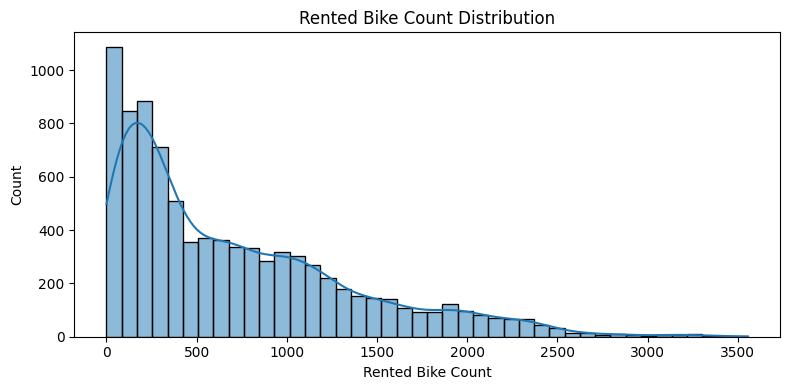

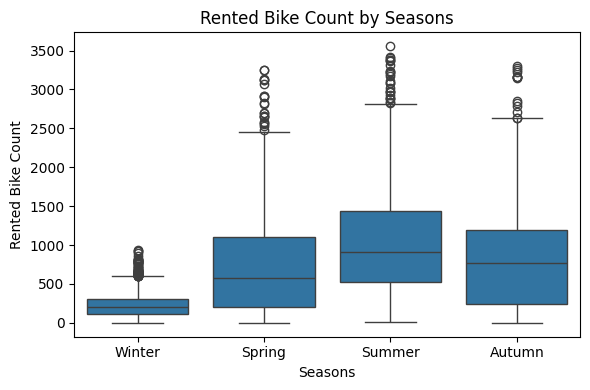

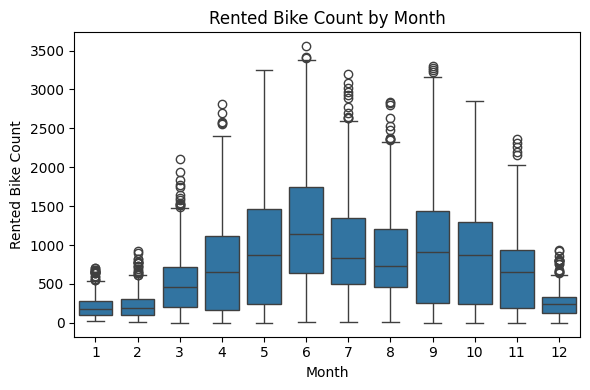

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\1106935318.py:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


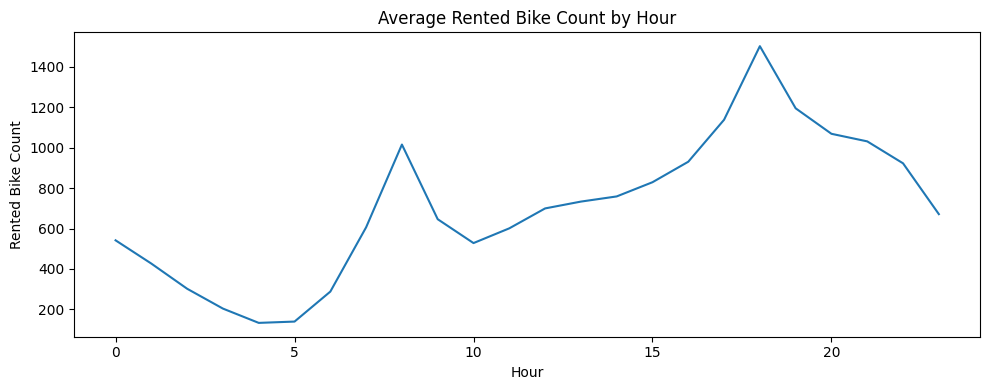

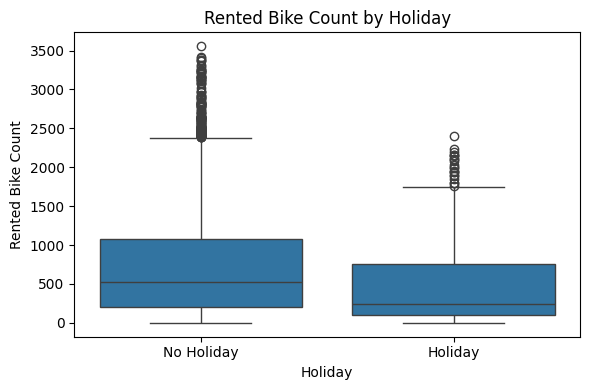

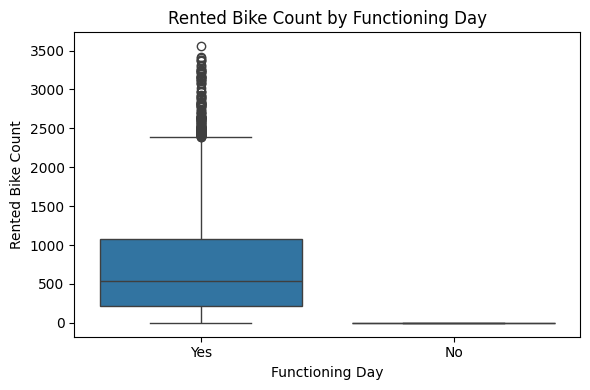

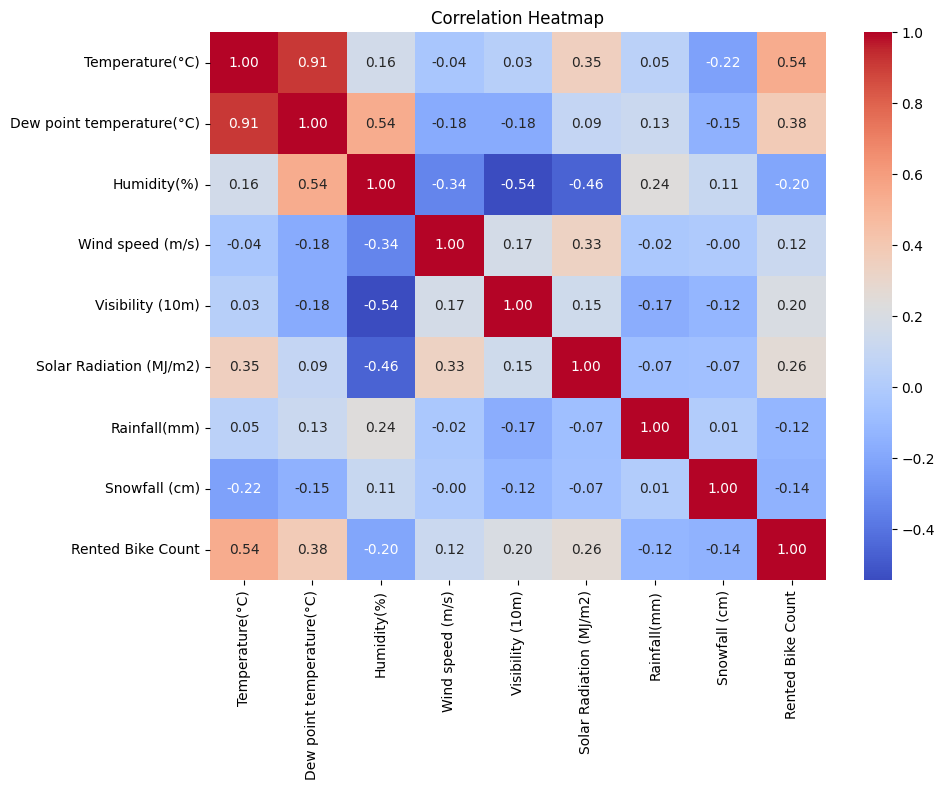

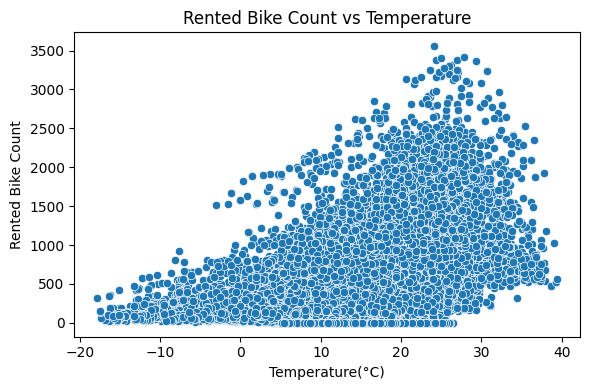

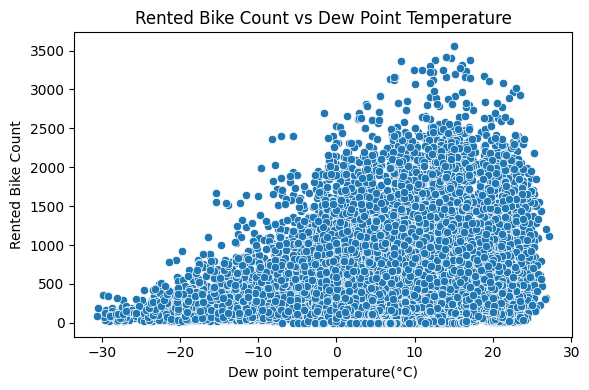

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\1106935318.py:128: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


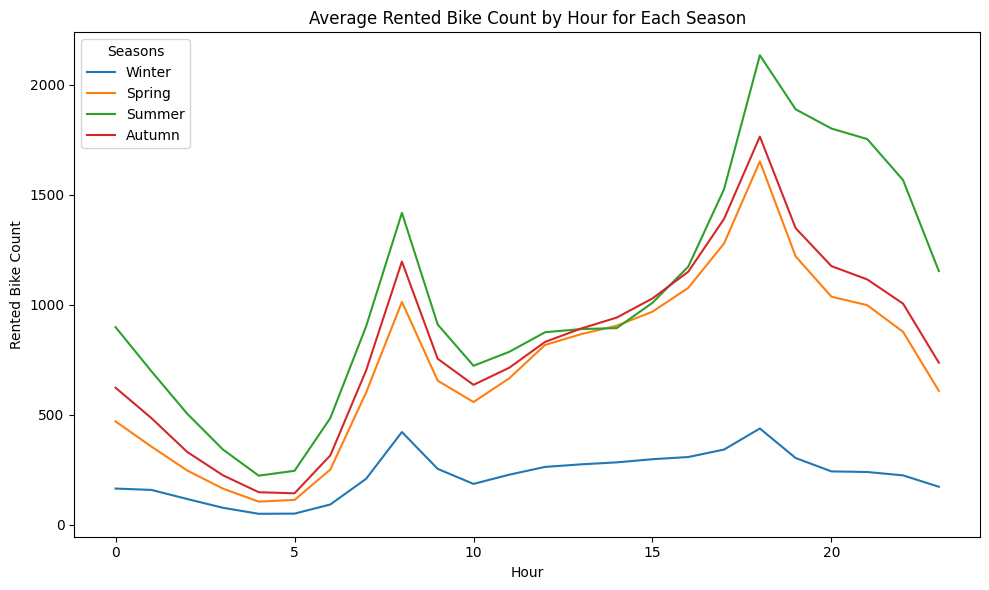

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15
Epoch 1/100: train 0.3718 | val 0.4122
Epoch 2/100: train 0.2415 | val 0.2902
Epoch 3/100: train 0.2013 | val 0.2299
Epoch 4/100: train 0.1667 | val 0.2251
Epoch 5/100: train 0.1499 | val 0.1864
Epoch 6/100: train 0.1287 | val 0.2155
Epoch 7/100: train 0.1232 | val 0.1448
Epoch 8/100: train 0.1042 | val 0.1305
Epoch 9/100: train 0.0927 | val 0.1346
Epoch 10/100: train 0.0819 | val 0.1222
Epoch 11/100: train 0.0735 | val 0.1134
Epoch 12/100: train 0.0597 | val 0.1134
Epoch 13/100: train 0.0544 | val 0.0923
Epoch 14/100: train 0.0474 | val 0.0787
Epoch 15/100: train 0.0459 | val 0.0816
Epoch 16/100: train 0.0488 | val 0.0776
Epoch 17/100: train 0.0445 | val 0.0892
Epoch 18/100: train 0.0445 | val 0.0592
Epoch 19/100: train 0.0453 | val 0.0682
Epoch 20/100: train 0.0360 | val 0.0642
Epoch 21/100: train 0.0407 | val 0.0671
Epoch 22/100: train 0.0397 | val 0.0502
Epoch 23/100: train 0.0423 | va

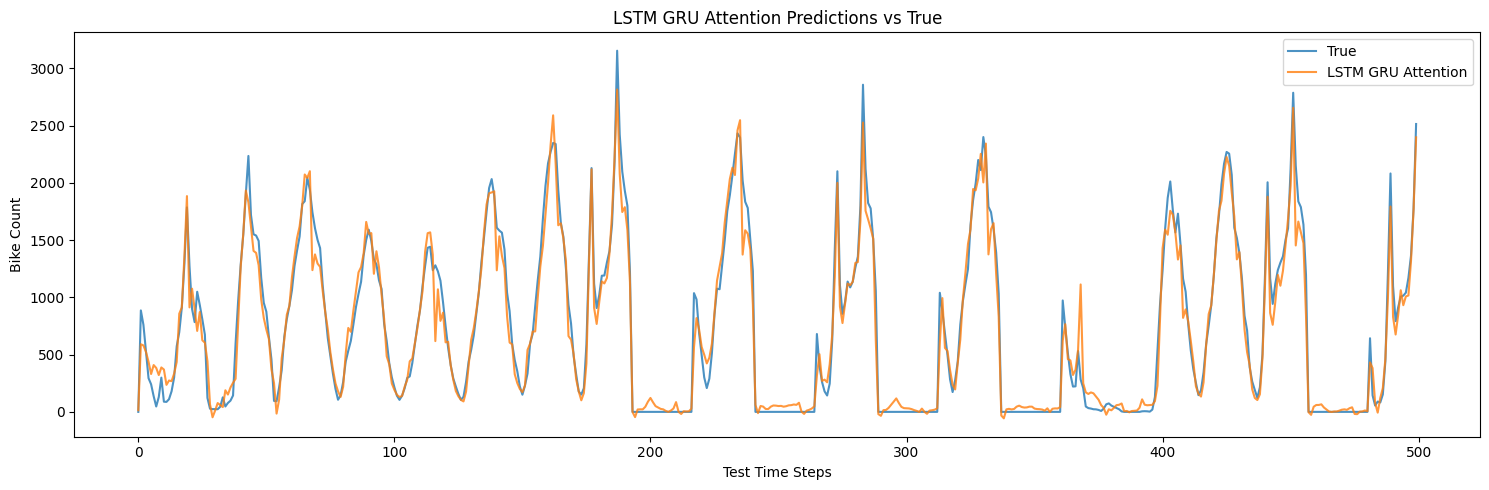

LSTM GRU Attention training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering 
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]
train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection & Scaling 
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# Deep LSTM + GRU with Attention
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_size, dropout=0.4):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.gru = nn.GRU(64, 32, batch_first=True)
        self.attn_fc = nn.Linear(32, 32)
        self.attn_score = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # x: [B, T, F]
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.gru(x) 
        attn_weights = torch.tanh(self.attn_fc(x))
        attn_weights = torch.softmax(self.attn_score(attn_weights), dim=1)
        x = (x * attn_weights).sum(dim=1)  
        x = self.dropout(x)
        return self.fc(x)  



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLSTMGRUAttention(input_size=X_train_seq.shape[2], dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3,weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== LSTM GRU Attention TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)
 
mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== LSTM GRU Attention TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")


plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='LSTM GRU Attention', alpha=0.8)
plt.legend()
plt.title('LSTM GRU Attention Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("LSTM GRU Attention training complete!")



Model 1: LSTM+GRU Next Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

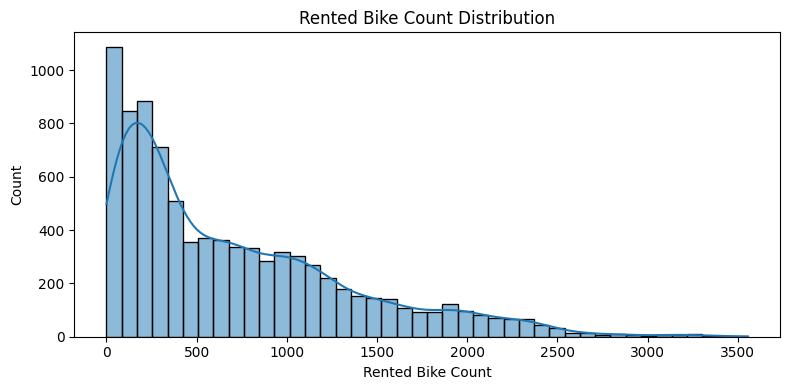

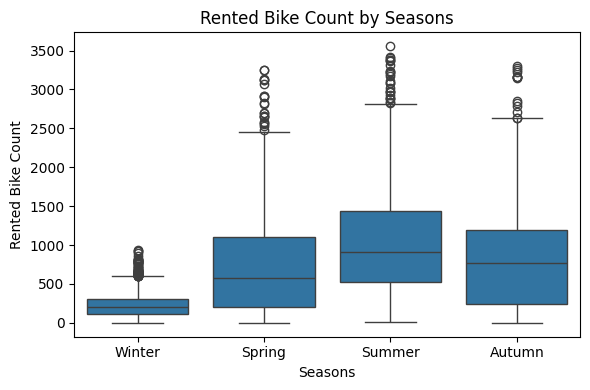

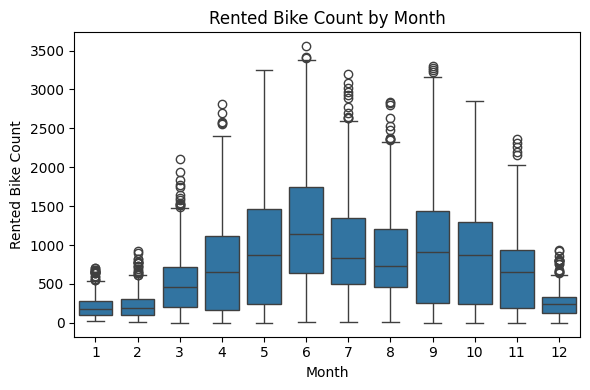

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\393008564.py:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


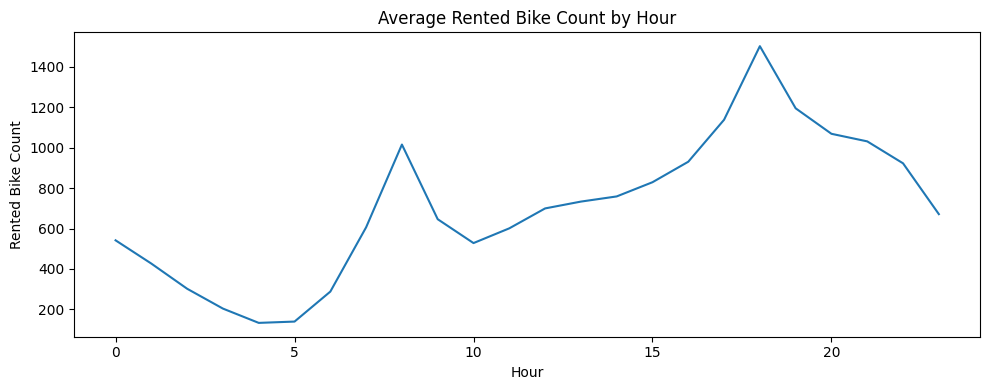

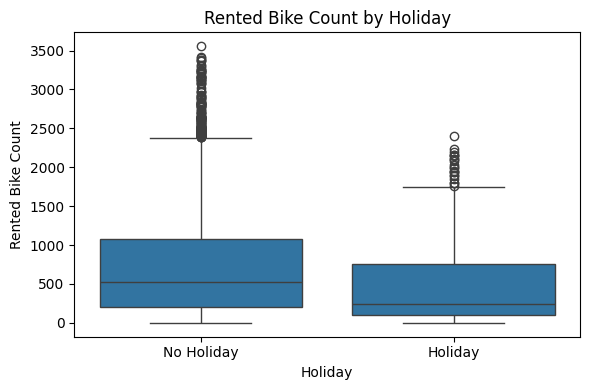

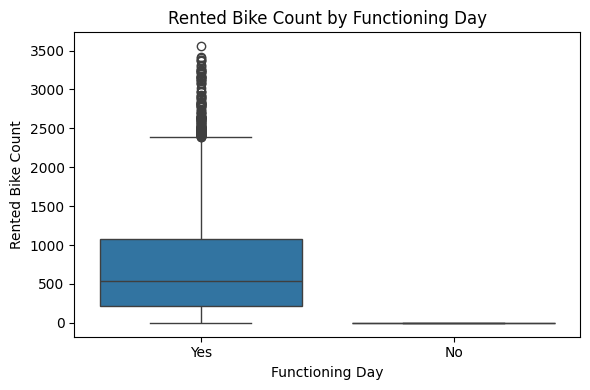

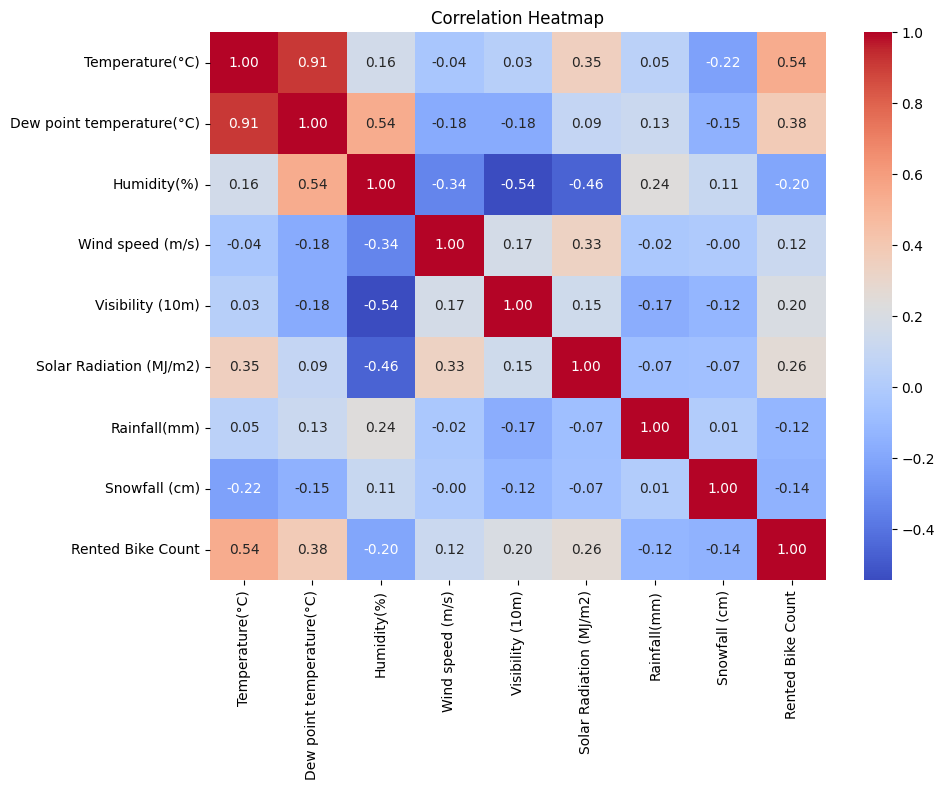

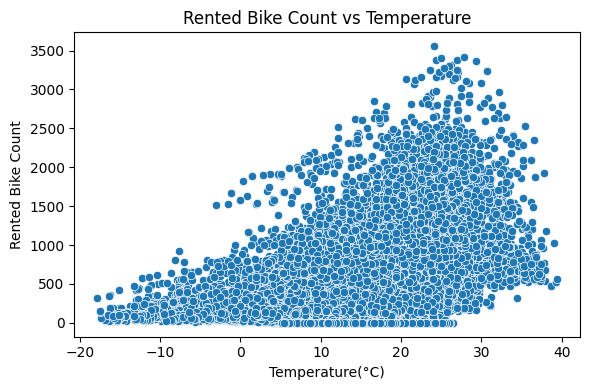

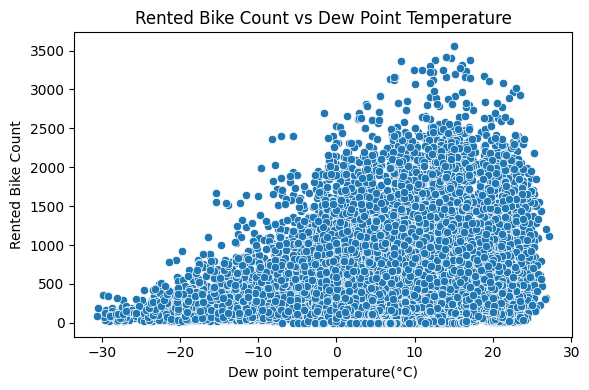

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\393008564.py:128: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


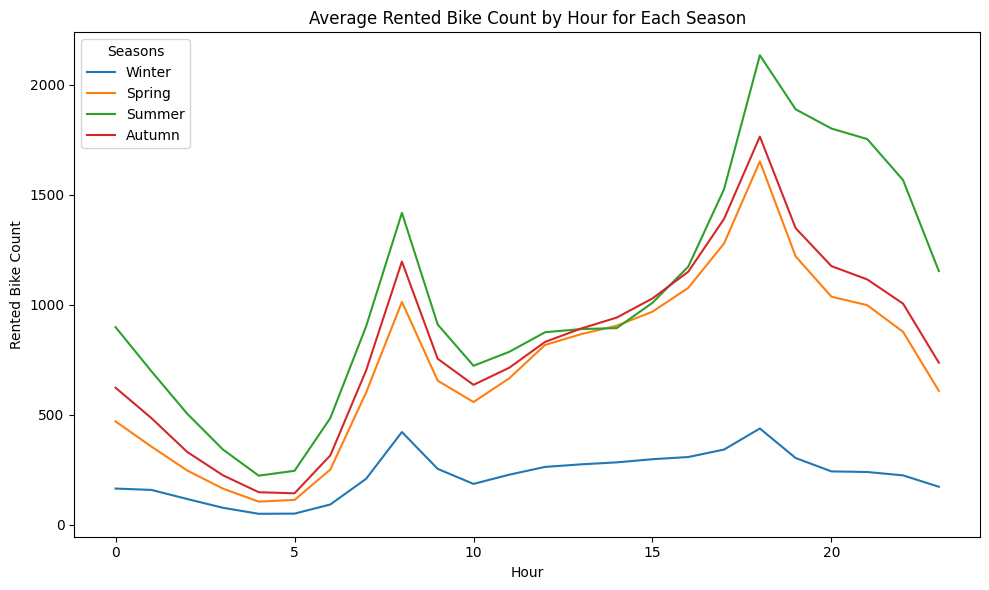

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15
Epoch 1/100: train 0.3874 | val 0.4114
Epoch 2/100: train 0.2663 | val 0.4206
Epoch 3/100: train 0.2327 | val 0.3319
Epoch 4/100: train 0.2056 | val 0.2655
Epoch 5/100: train 0.1869 | val 0.2582
Epoch 6/100: train 0.1662 | val 0.2465
Epoch 7/100: train 0.1559 | val 0.2659
Epoch 8/100: train 0.1410 | val 0.2630
Epoch 9/100: train 0.1321 | val 0.2200
Epoch 10/100: train 0.1234 | val 0.2235
Epoch 11/100: train 0.1194 | val 0.2173
Epoch 12/100: train 0.1113 | val 0.1767
Epoch 13/100: train 0.1106 | val 0.2056
Epoch 14/100: train 0.1012 | val 0.2214
Epoch 15/100: train 0.0997 | val 0.1951
Epoch 16/100: train 0.0962 | val 0.2531
Epoch 17/100: train 0.0925 | val 0.1841
Epoch 18/100: train 0.0868 | val 0.1681
Epoch 19/100: train 0.0885 | val 0.1772
Epoch 20/100: train 0.0847 | val 0.2048
Epoch 21/100: train 0.0817 | val 0.2221
Epoch 22/100: train 0.0790 | val 0.1801
Epoch 23/100: train 0.0807 | va

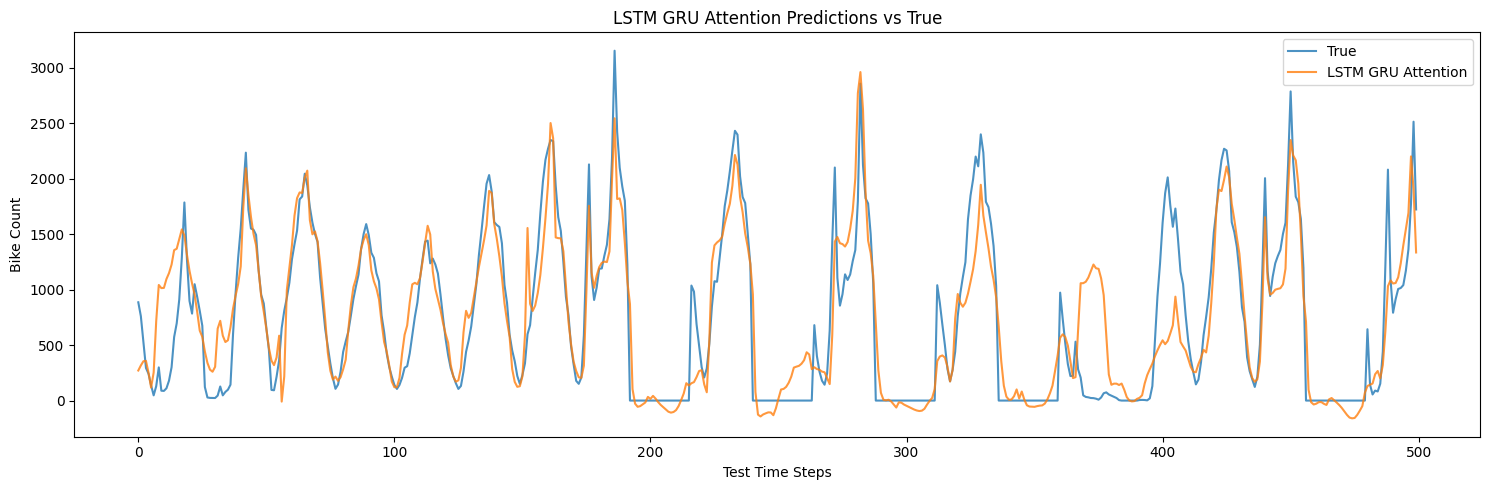

LSTM GRU Attention training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering 
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]
train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection & Scaling 
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# Deep LSTM + GRU with Attention
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_size, dropout=0.4):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.gru = nn.GRU(64, 32, batch_first=True)
        self.attn_fc = nn.Linear(32, 32)
        self.attn_score = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # x: [B, T, F]
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.gru(x) 
        attn_weights = torch.tanh(self.attn_fc(x))
        attn_weights = torch.softmax(self.attn_score(attn_weights), dim=1)
        x = (x * attn_weights).sum(dim=1)  
        x = self.dropout(x)
        return self.fc(x)  



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLSTMGRUAttention(input_size=X_train_seq.shape[2], dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3,weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== LSTM GRU Attention TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)
 
mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== LSTM GRU Attention TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")


plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='LSTM GRU Attention', alpha=0.8)
plt.legend()
plt.title('LSTM GRU Attention Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("LSTM GRU Attention training complete!")



Model 2: ConvLSTM Current Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

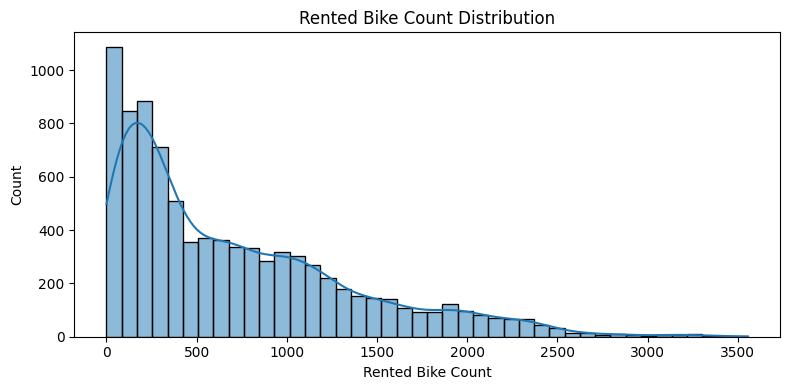

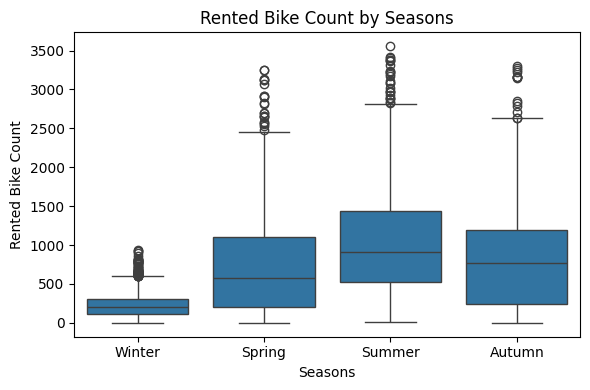

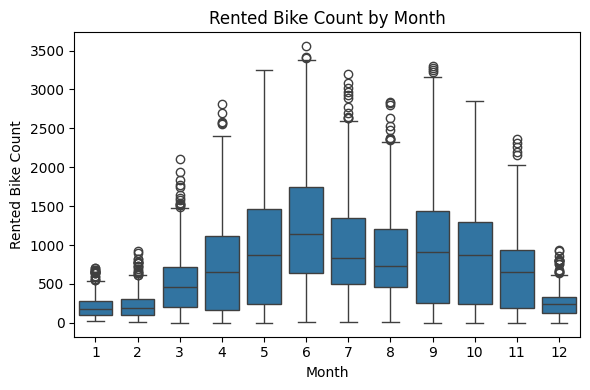

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\3470051693.py:81: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


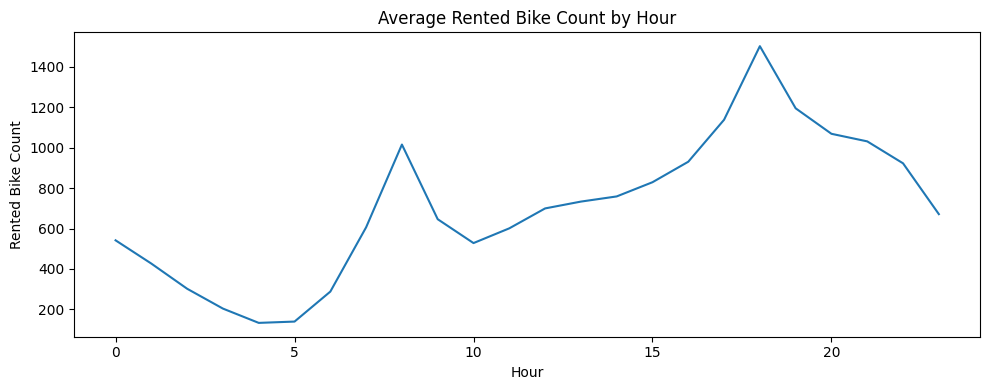

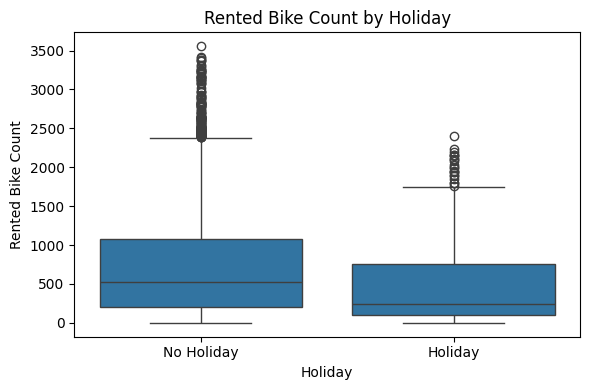

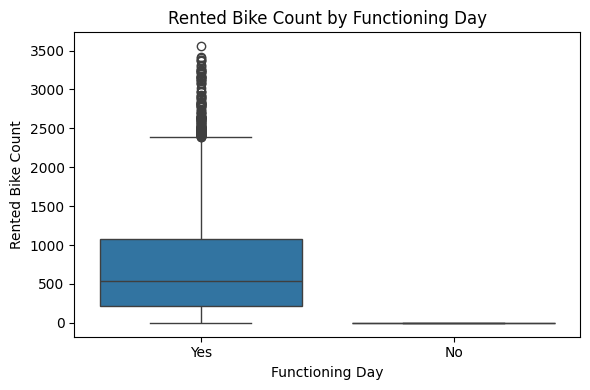

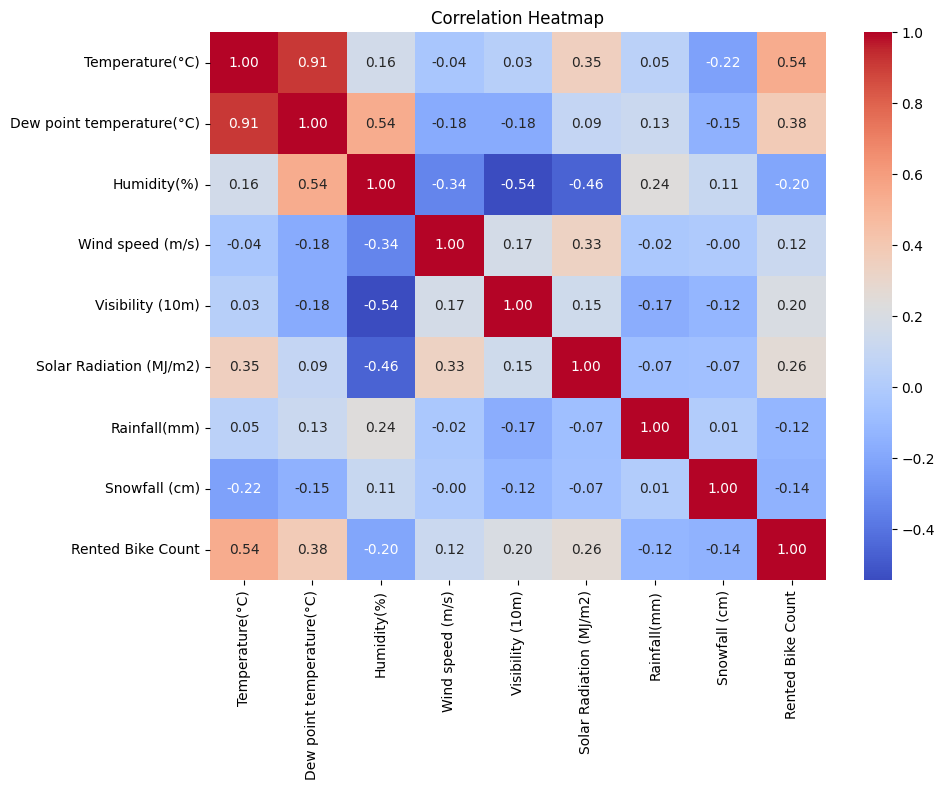

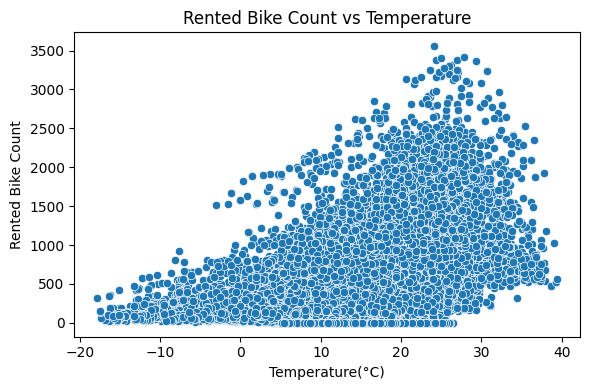

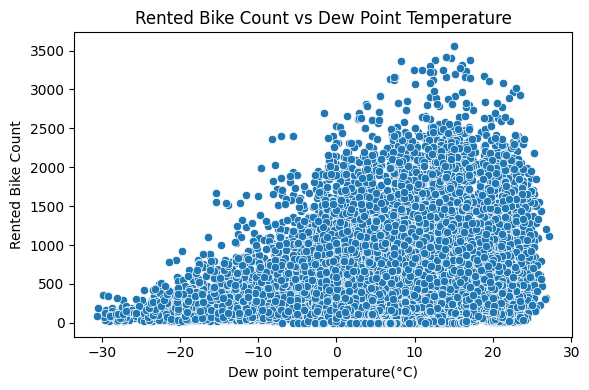

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\3470051693.py:129: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


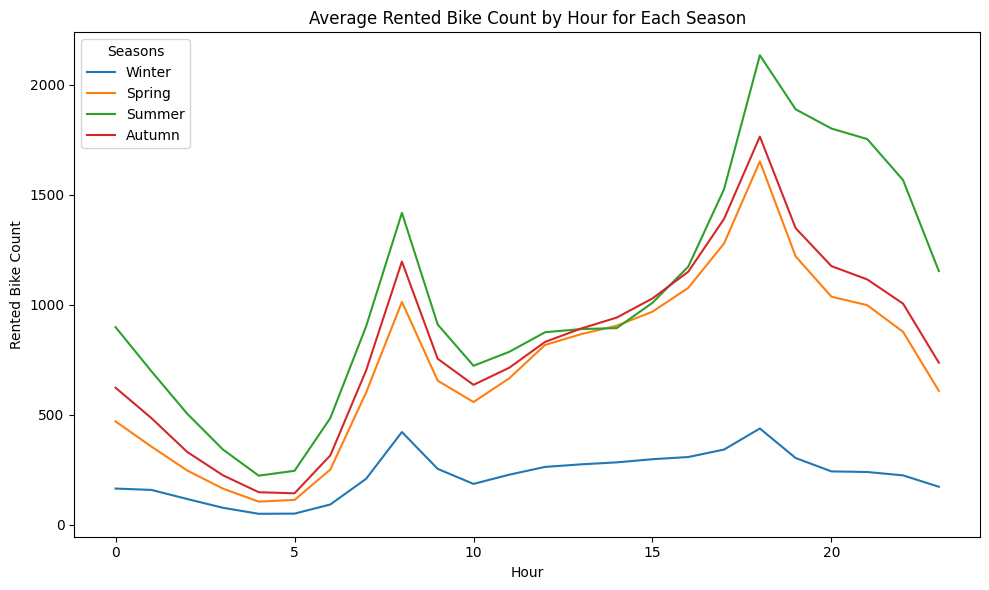

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15
ConvLSTM  input 15 
Epoch 1/100: train 0.3734 | val 0.3599
Epoch 2/100: train 0.1558 | val 0.2182
Epoch 3/100: train 0.1145 | val 0.1636
Epoch 4/100: train 0.0880 | val 0.1463
Epoch 5/100: train 0.0809 | val 0.1662
Epoch 6/100: train 0.0722 | val 0.1238
Epoch 7/100: train 0.0672 | val 0.1255
Epoch 8/100: train 0.0616 | val 0.1104
Epoch 9/100: train 0.0561 | val 0.0962
Epoch 10/100: train 0.0541 | val 0.1078
Epoch 11/100: train 0.0505 | val 0.1238
Epoch 12/100: train 0.0476 | val 0.0923
Epoch 13/100: train 0.0441 | val 0.0861
Epoch 14/100: train 0.0429 | val 0.0865
Epoch 15/100: train 0.0433 | val 0.0861
Epoch 16/100: train 0.0401 | val 0.1079
Epoch 17/100: train 0.0395 | val 0.0775
Epoch 18/100: train 0.0377 | val 0.0810
Epoch 19/100: train 0.0362 | val 0.0805
Epoch 20/100: train 0.0380 | val 0.0705
Epoch 21/100: train 0.0348 | val 0.0789
Epoch 22/100: train 0.0350 | val 0.0820
Epoch 23/10

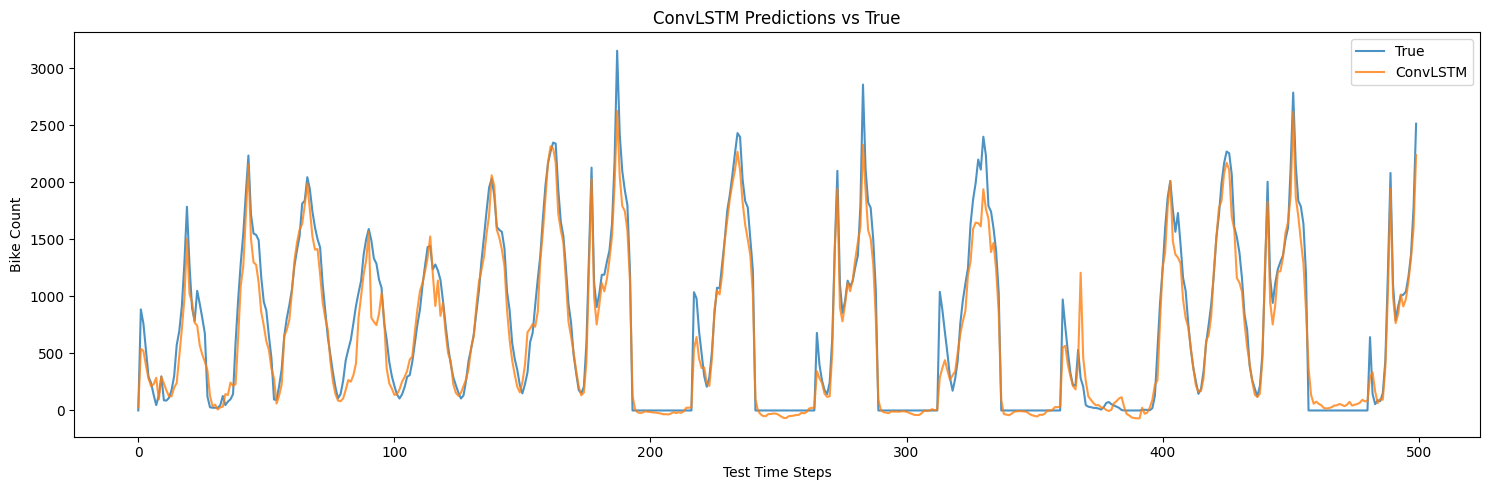

ConvLSTM training complete!


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping helper
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering 
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]
train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection & Scaling 
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ConvLSTM
class ConvLSTM(nn.Module):  
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  
        final_h = self.dropout(final_h)
        return self.fc(final_h)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.2)
print(f"ConvLSTM  input {n_features} ")
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)

model.to(device)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== ConvLSTM TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)
 
mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== ConvLSTM TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")


plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='ConvLSTM', alpha=0.8)
plt.legend()
plt.title('ConvLSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("ConvLSTM training complete!")



Model 2: ConvLSTM Next Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

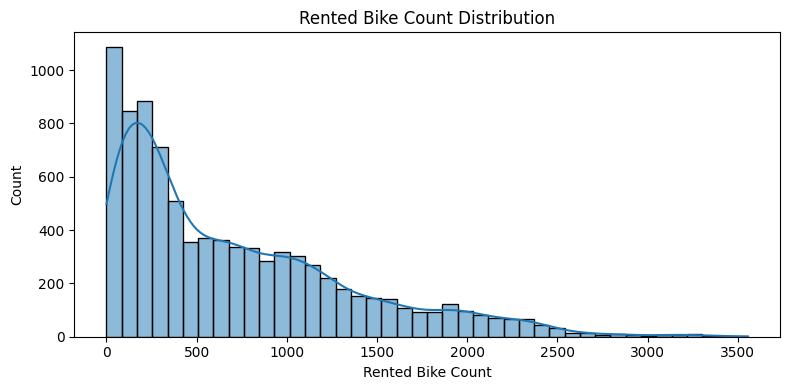

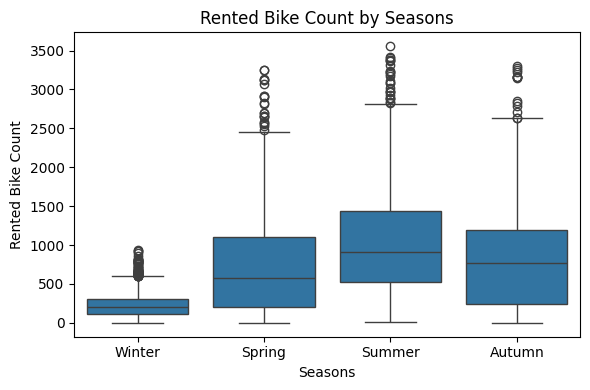

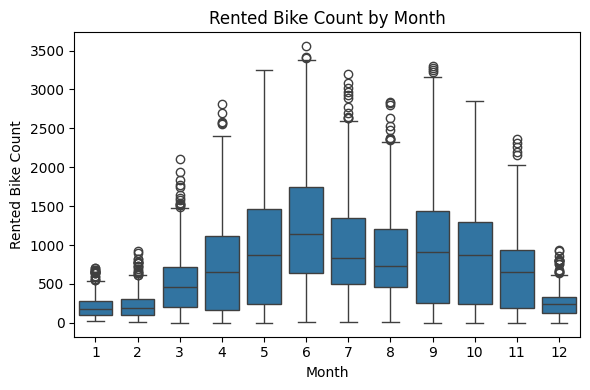

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\4212076645.py:81: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


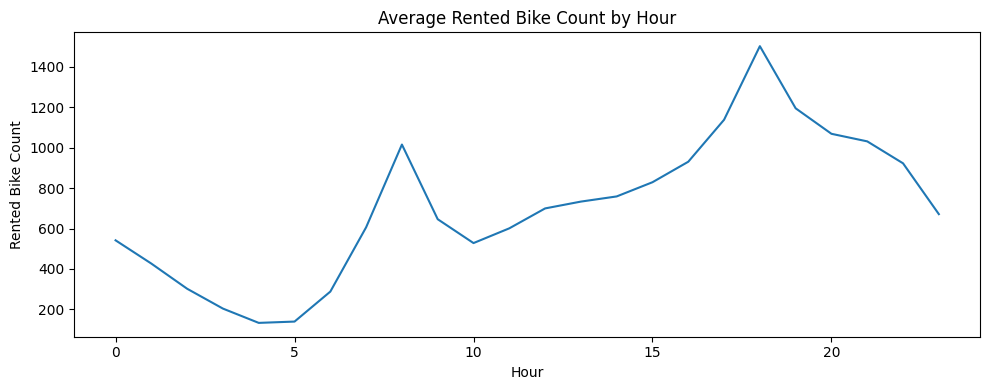

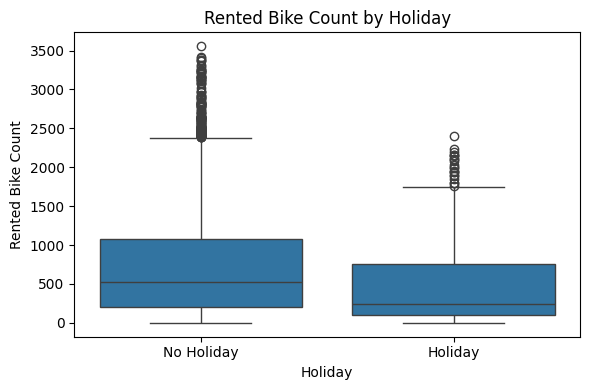

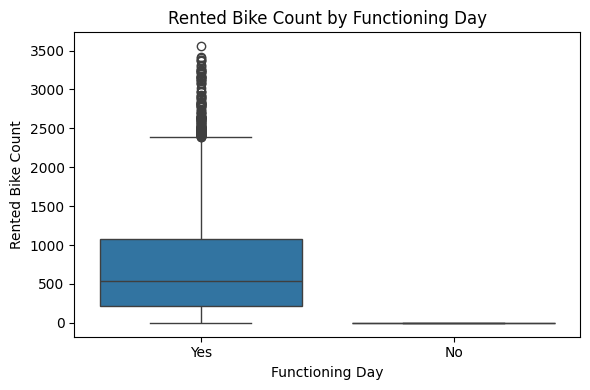

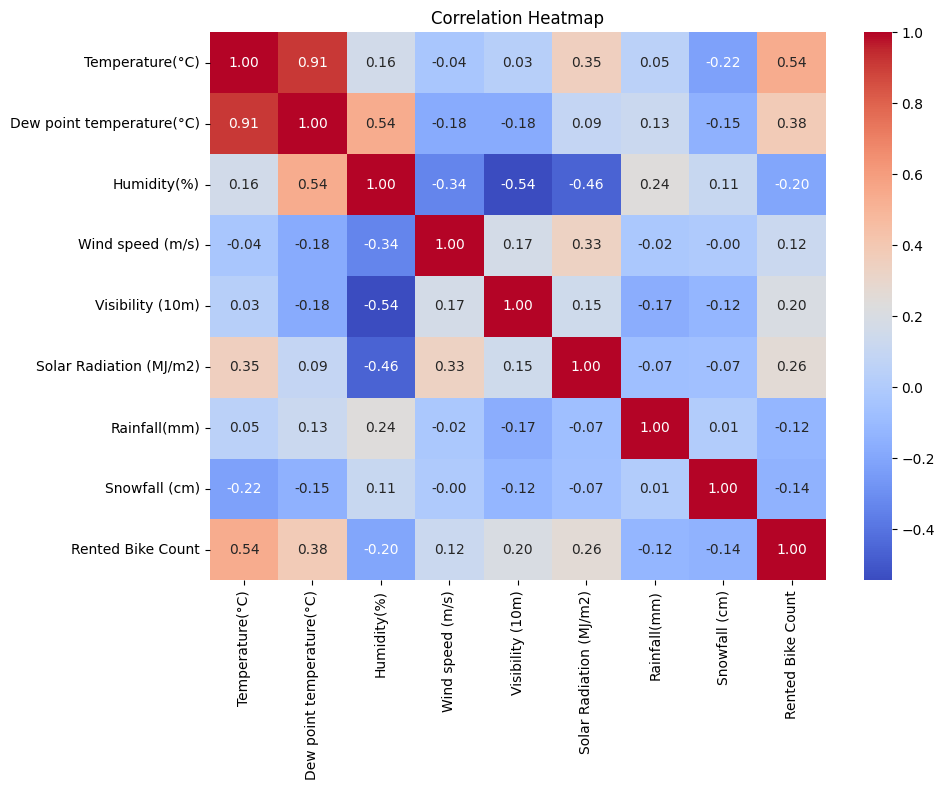

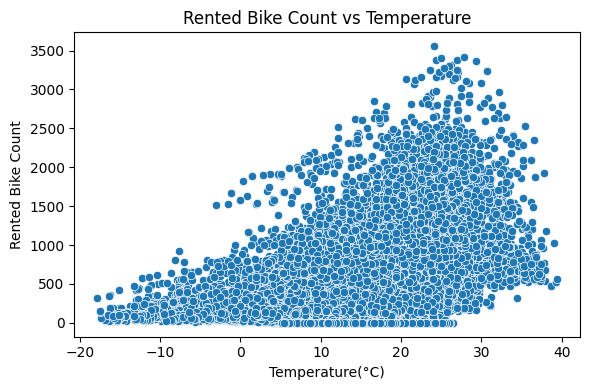

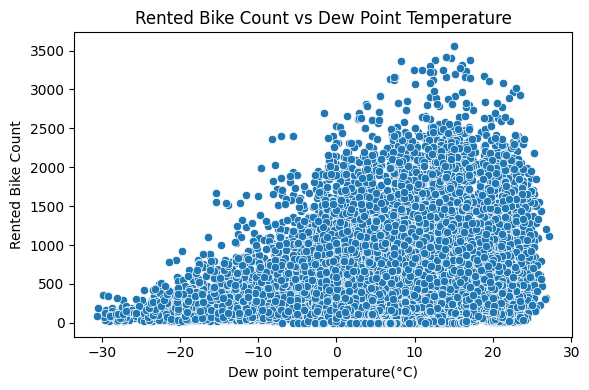

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\4212076645.py:129: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


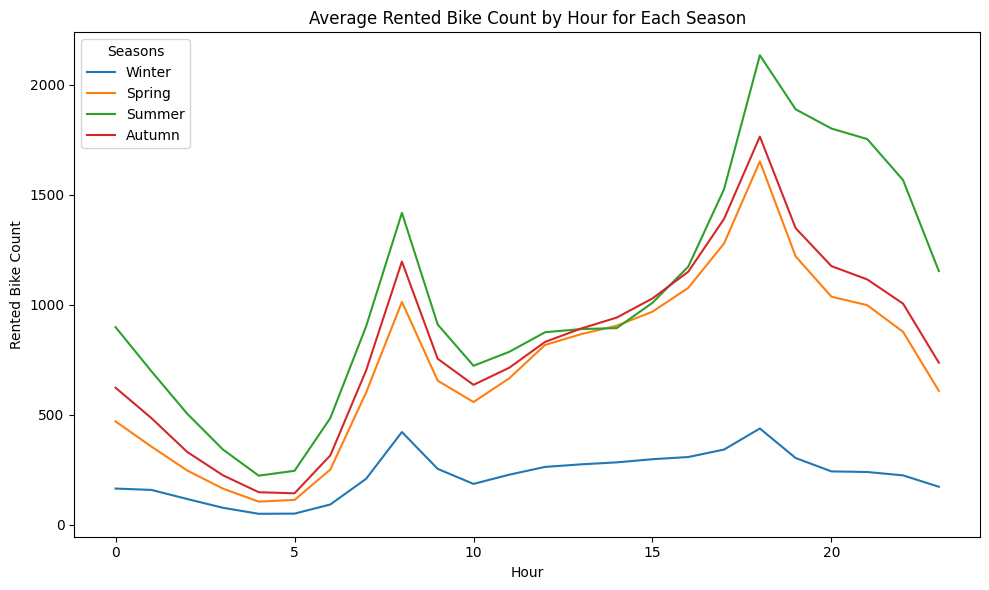

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15
ConvLSTM  input 15 
Epoch 1/100: train 0.3893 | val 0.3875
Epoch 2/100: train 0.1830 | val 0.2913
Epoch 3/100: train 0.1363 | val 0.2288
Epoch 4/100: train 0.1139 | val 0.2083
Epoch 5/100: train 0.1035 | val 0.2038
Epoch 6/100: train 0.0979 | val 0.2002
Epoch 7/100: train 0.0892 | val 0.1883
Epoch 8/100: train 0.0836 | val 0.1653
Epoch 9/100: train 0.0807 | val 0.1563
Epoch 10/100: train 0.0736 | val 0.1667
Epoch 11/100: train 0.0726 | val 0.1826
Epoch 12/100: train 0.0692 | val 0.1704
Epoch 13/100: train 0.0662 | val 0.1649
Epoch 14/100: train 0.0636 | val 0.1416
Epoch 15/100: train 0.0615 | val 0.1565
Epoch 16/100: train 0.0620 | val 0.1759
Epoch 17/100: train 0.0600 | val 0.1452
Epoch 18/100: train 0.0561 | val 0.1570
Epoch 19/100: train 0.0558 | val 0.1367
Epoch 20/100: train 0.0549 | val 0.1446
Epoch 21/100: train 0.0545 | val 0.1454
Epoch 22/100: train 0.0546 | val 0.1381
Epoch 23/10

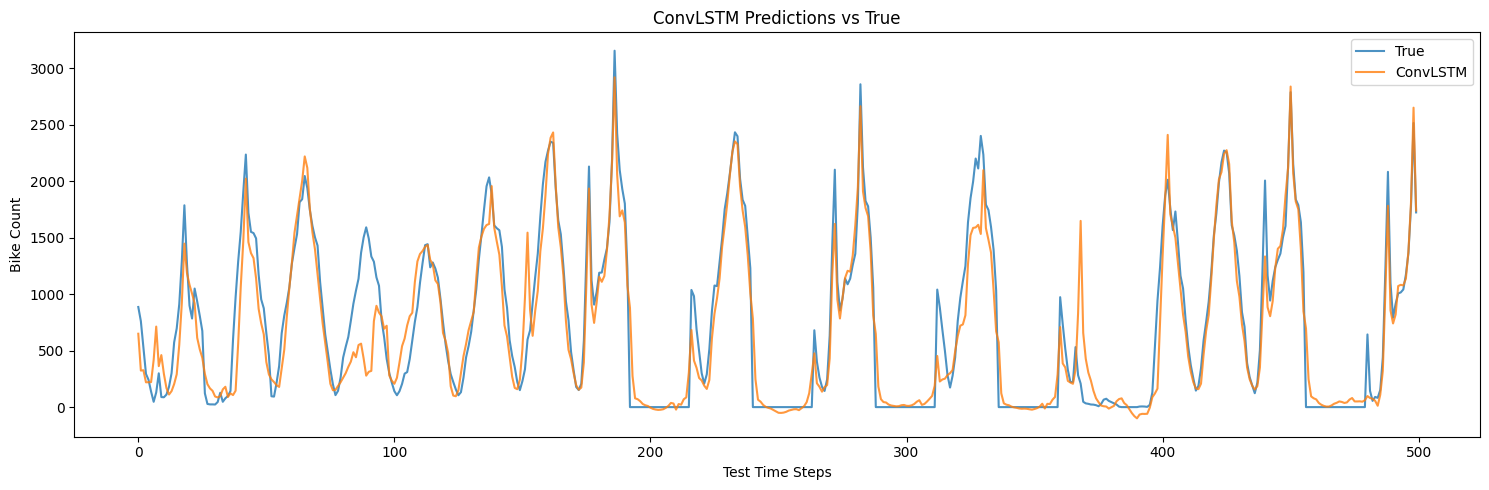

ConvLSTM training complete!


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering 
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]
train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection & Scaling 
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ConvLSTM
class ConvLSTM(nn.Module):  
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  
        final_h = self.dropout(final_h)
        return self.fc(final_h)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.2)
print(f"ConvLSTM  input {n_features} ")
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)

model.to(device)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== ConvLSTM TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)
 
mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== ConvLSTM TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")


plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='ConvLSTM', alpha=0.8)
plt.legend()
plt.title('ConvLSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("ConvLSTM training complete!")



Model 3: LSTM + Random Forest Current Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

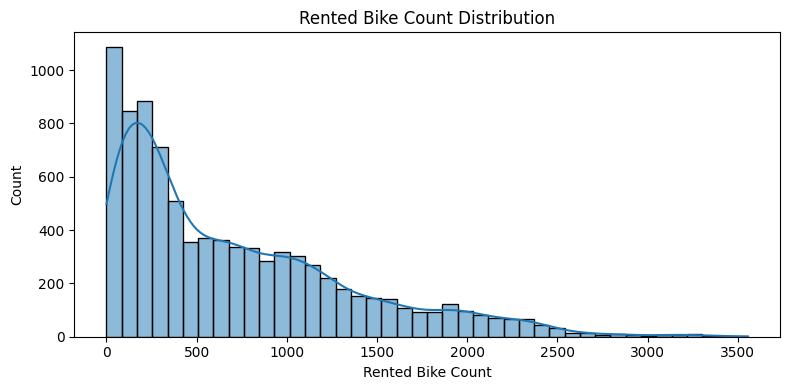

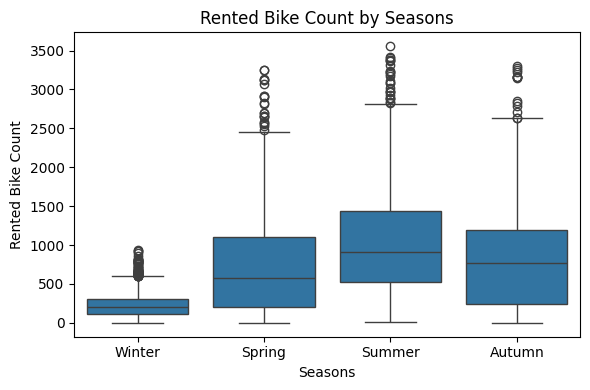

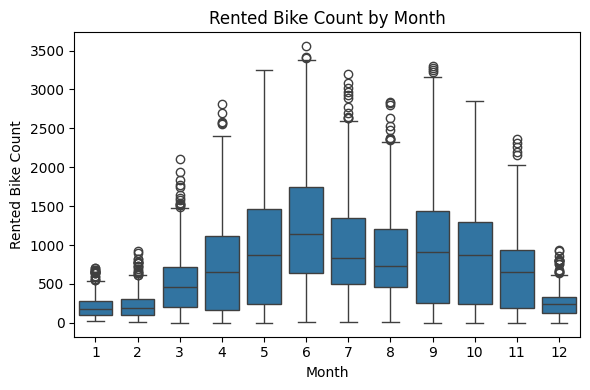

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\1172892006.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


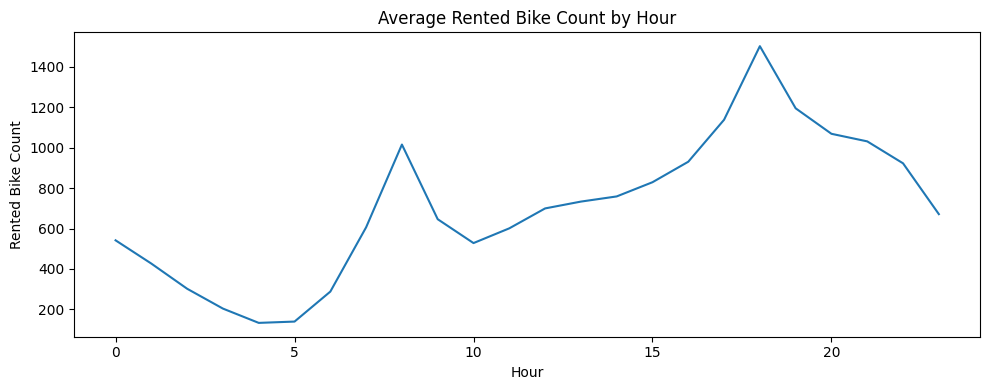

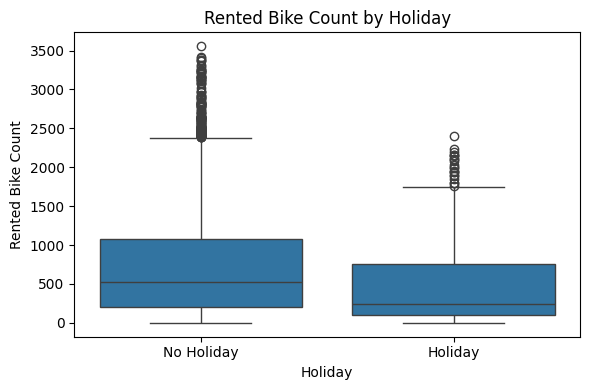

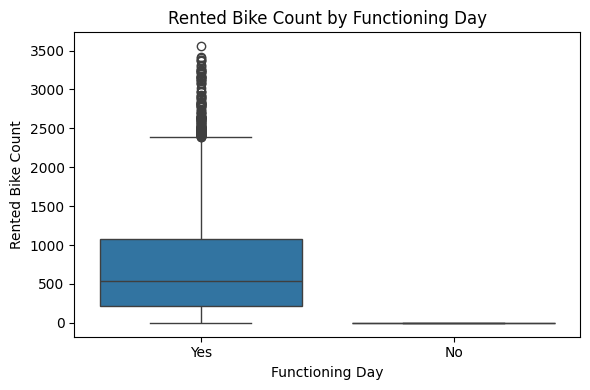

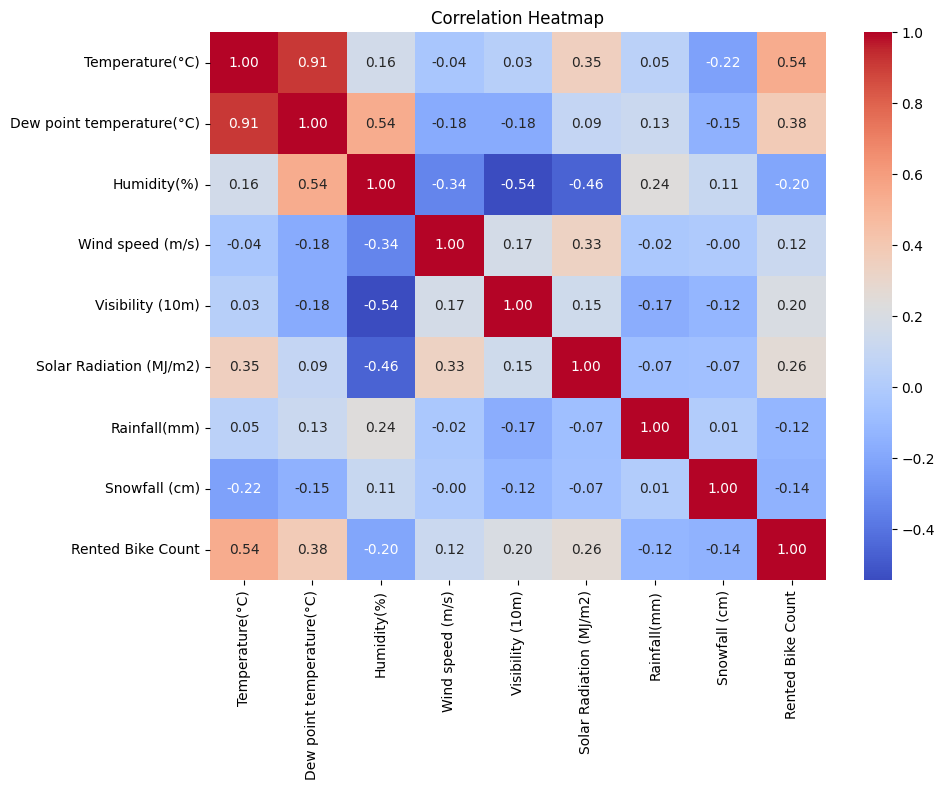

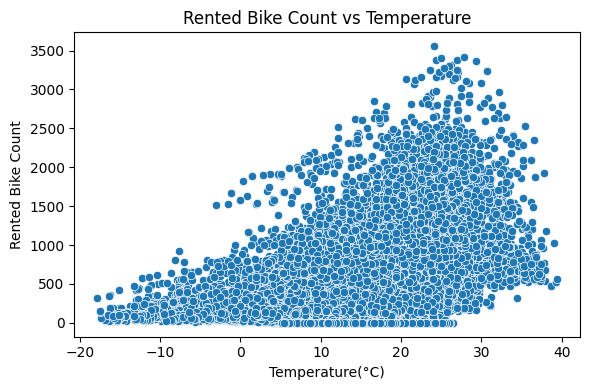

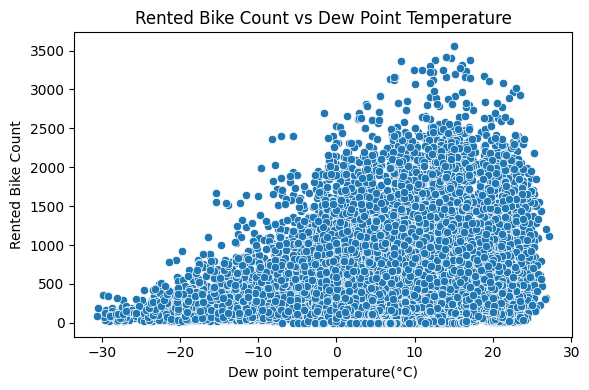

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\1172892006.py:130: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


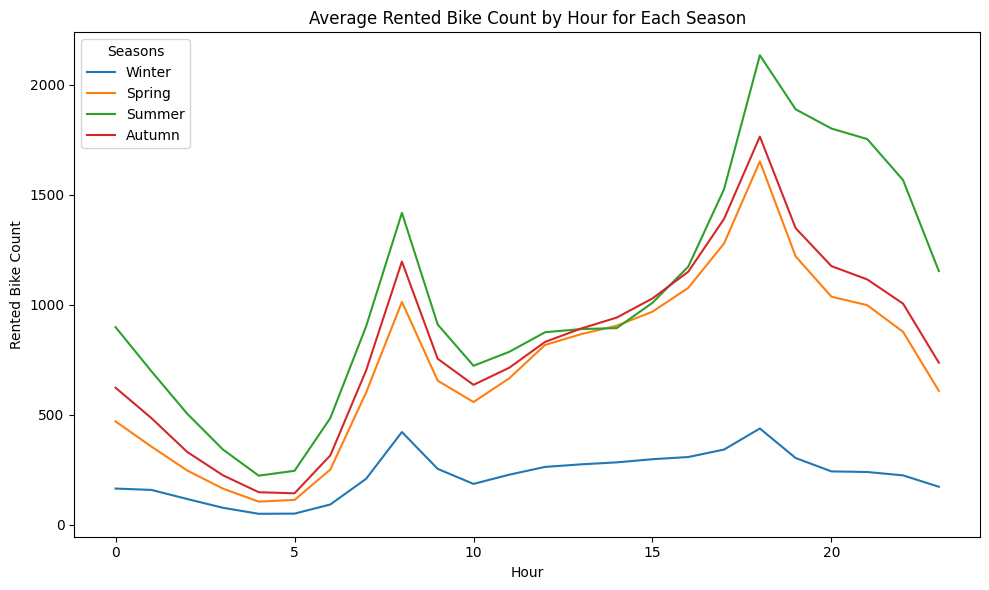

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1/100: train 0.5197 | val 0.4696
Epoch 2/100: train 0.2564 | val 0.3682
Epoch 3/100: train 0.2150 | val 0.2980
Epoch 4/100: train 0.1843 | val 0.2722
Epoch 5/100: train 0.1643 | val 0.2210
Epoch 6/100: train 0.1472 | val 0.2077
Epoch 7/100: train 0.1333 | val 0.1732
Epoch 8/100: train 0.1226 | val 0.1571
Epoch 9/100: train 0.1121 | val 0.1334
Epoch 10/100: train 0.1001 | val 0.1297
Epoch 11/100: train 0.0892 | val 0.1045
Epoch 12/100: train 0.0782 | val 0.0972
Epoch 13/100: train 0.0727 | val 0.0855
Epoch 14/100: train 0.0653 | val 0.0942
Epoch 15/100: train 0.0600 | val 0.0761
Epoch 16/100: train 0.0572 | val 0.0772
Epoch 17/100: train 0.0540 | val 0.0617
Epoch 18/100: train 0.0511 | val 0.0645
Epoch 19/100: train 0.0481 | val 0.0578
Epoch 20/100: train 0.0456 | val 0.0579
Epoch 21/100: train 0.0443 | val 0.0577
Epoch 22/100: train 0.0441 | val 0.0521
Epoch 23/100: train 0.0404 | val 0.0551
Epoch 24/100: train 0.0401 | val 0.0571
Epoch 25/100: train 0.0407 | val 0.0510
Epoch 26/

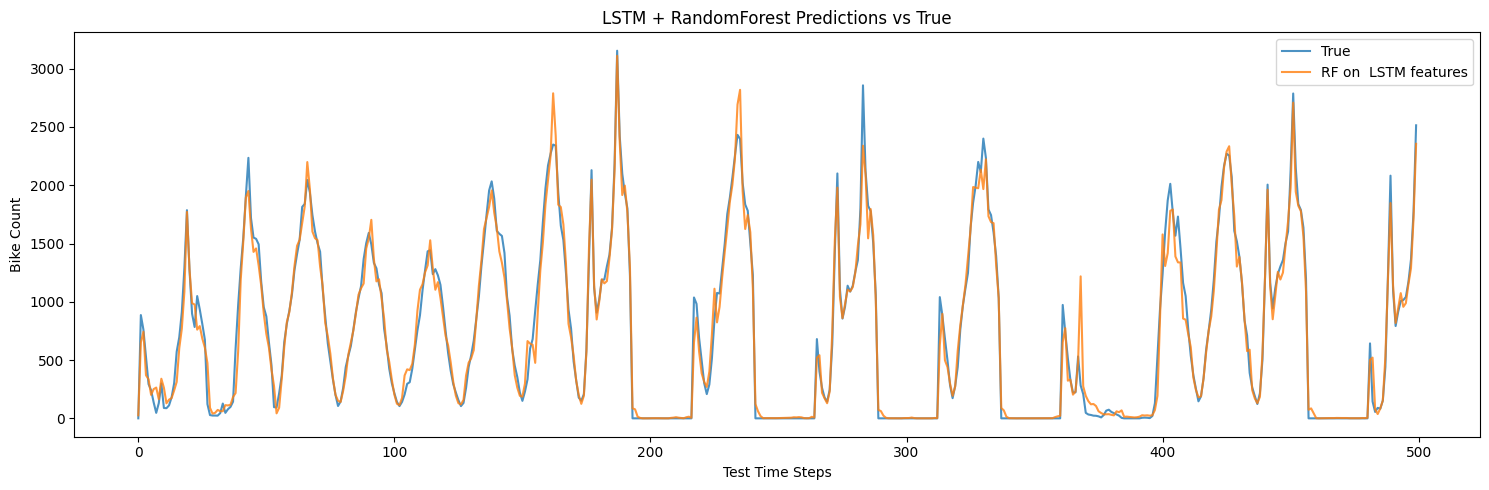

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})


    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

#  Feature selection and Scaling
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation 
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):  
        X_seq.append(X[i:i + seq_len])     
        y_seq.append(y[i + seq_len - 1])       
    return np.array(X_seq), np.array(y_seq)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

#  LSTM Model 
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=34, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True, dropout=dropout)
        self.lstm3 = nn.LSTM(hidden_dim2, hidden_dim3, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim3, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        output = self.fc(out)
        return output

input_dim = n_features
model = LSTM(input_dim=input_dim, dropout=0.25)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Extract LSTM features for RF 
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out, _ = model.lstm1(xb)
            out, _ = model.lstm2(out)
            out, _ = model.lstm3(out)
            feats = out[:, -1, :]  
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats, test_targets_scaled = extract_features(model, test_loader_full, device)

train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets = scaler_y.inverse_transform(test_targets_scaled)

# RandomForest on LSTM features 
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# Evaluation on TRAIN set
rf_train_preds = rf.predict(train_feats)

y_true_train_orig = train_targets
y_pred_train_orig = rf_train_preds.reshape(-1, 1)

train_mse = np.mean((y_true_train_orig - y_pred_train_orig) ** 2)
train_rmse = np.sqrt(train_mse)
train_mae = np.mean(np.abs(y_true_train_orig - y_pred_train_orig))

safe_idx_train = y_true_train_orig > 10
train_mape = np.mean(
    np.abs((y_true_train_orig[safe_idx_train] - y_pred_train_orig[safe_idx_train]) /
           y_true_train_orig[safe_idx_train])
) * 100

train_smape = np.mean(
    2 * np.abs(y_pred_train_orig - y_true_train_orig) /
    (np.abs(y_true_train_orig) + np.abs(y_pred_train_orig) + 1e-8)
) * 100

train_r2 = r2_score(y_true_train_orig, y_pred_train_orig)

print("\n=== LSTM features + RandomForest TRAIN Results ===")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Train SMAPE: {train_smape:.2f}%")
print(f"Train R2: {train_r2:.4f}")


# Evaluation on TEST set 
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== LSTM features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# Prediction plot 
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on  LSTM features', alpha=0.8)
plt.legend()
plt.title('LSTM + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


Model 3: LSTM + Random Forest Next Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

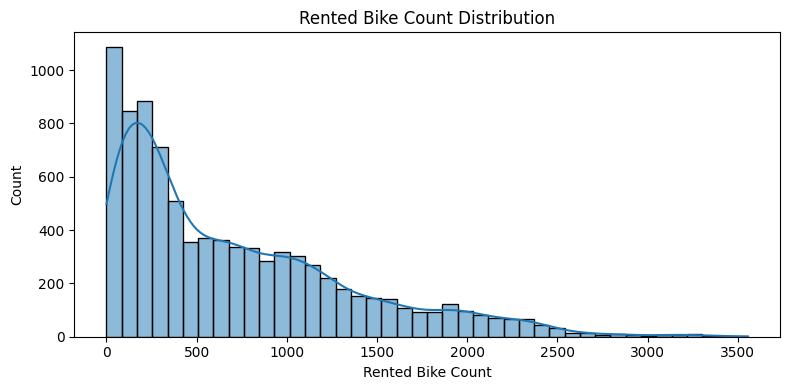

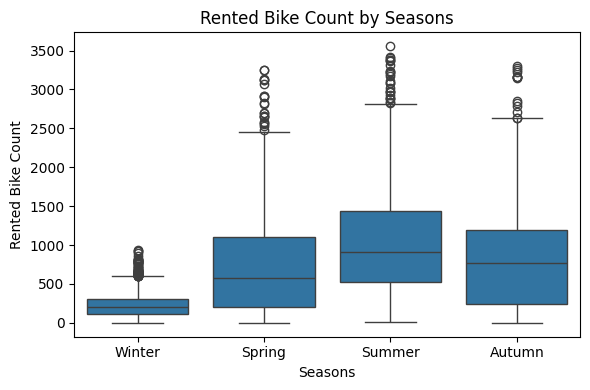

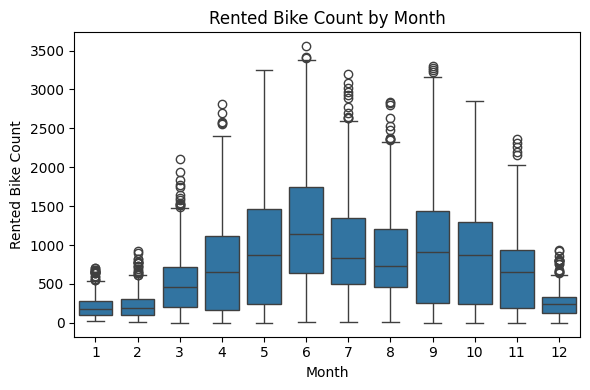

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\4129485375.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


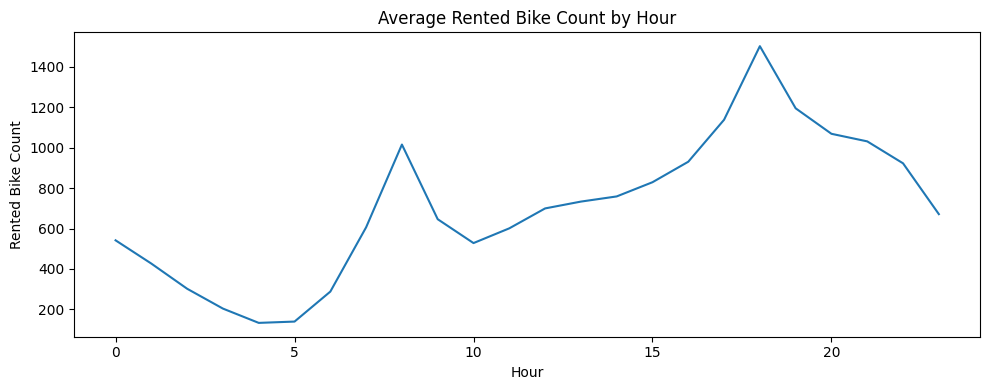

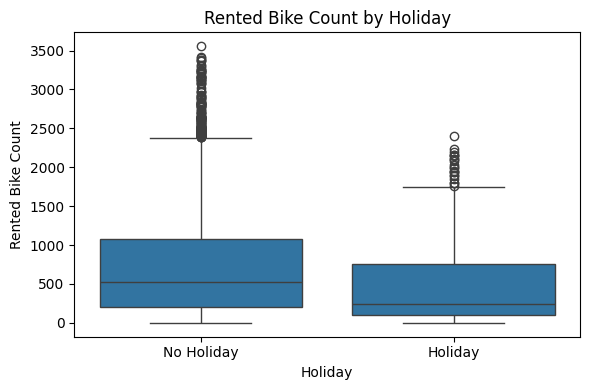

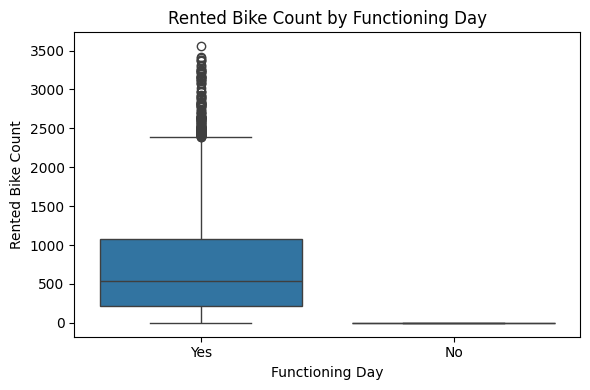

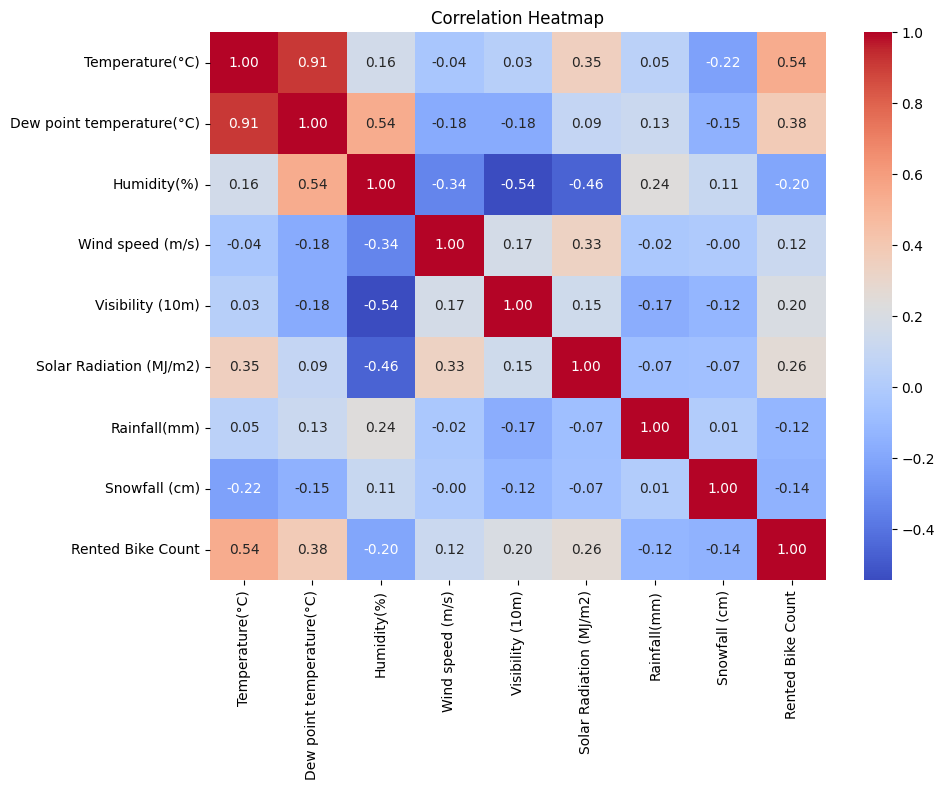

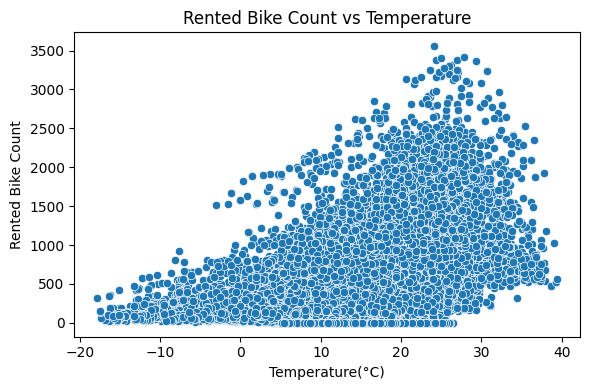

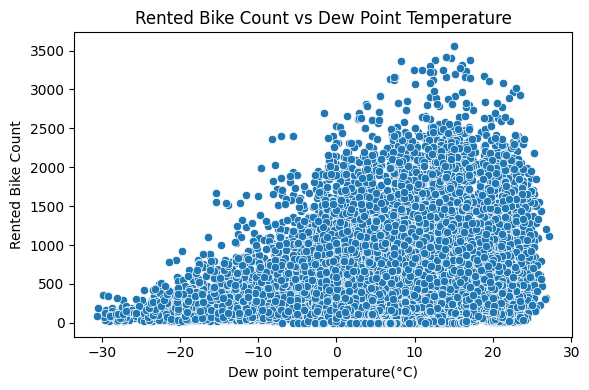

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\4129485375.py:130: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


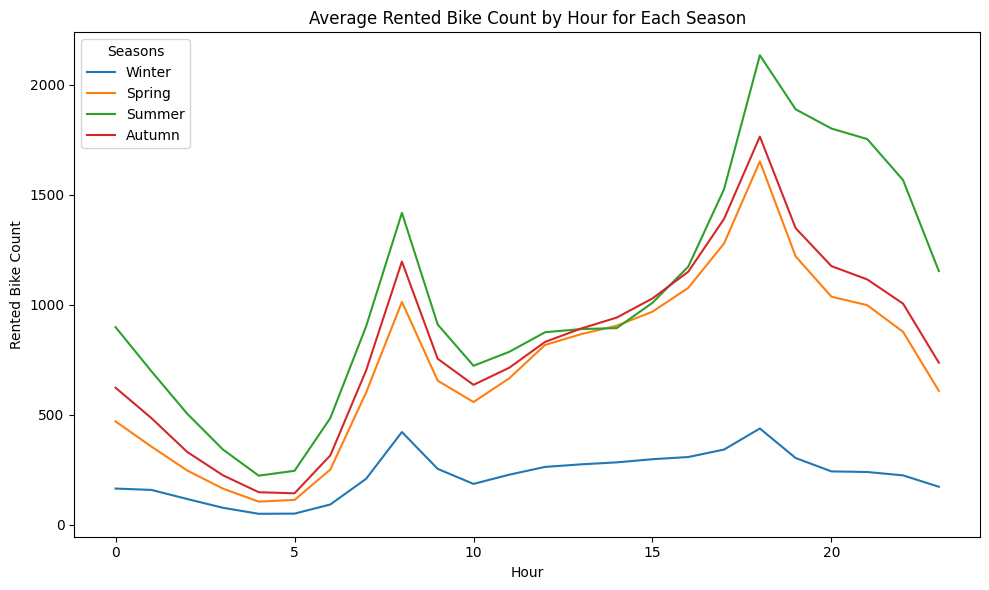

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1/100: train 0.5257 | val 0.4905
Epoch 2/100: train 0.2697 | val 0.4113
Epoch 3/100: train 0.2326 | val 0.3193
Epoch 4/100: train 0.2065 | val 0.2880
Epoch 5/100: train 0.1889 | val 0.2553
Epoch 6/100: train 0.1759 | val 0.2556
Epoch 7/100: train 0.1661 | val 0.2173
Epoch 8/100: train 0.1564 | val 0.2167
Epoch 9/100: train 0.1454 | val 0.1963
Epoch 10/100: train 0.1351 | val 0.1835
Epoch 11/100: train 0.1312 | val 0.1824
Epoch 12/100: train 0.1247 | val 0.1783
Epoch 13/100: train 0.1160 | val 0.1814
Epoch 14/100: train 0.1134 | val 0.1676
Epoch 15/100: train 0.1088 | val 0.1772
Epoch 16/100: train 0.1043 | val 0.1685
Epoch 17/100: train 0.1006 | val 0.1513
Epoch 18/100: train 0.0945 | val 0.1511
Epoch 19/100: train 0.0897 | val 0.1540
Epoch 20/100: train 0.0906 | val 0.1353
Epoch 21/100: train 0.0811 | val 0.1413
Epoch 22/100: train 0.0798 | val 0.1397
Epoch 23/100: train 0.0792 | val 0.1252
Epoch 24/100: train 0.0761 | val 0.1588
Epoch 25/100: train 0.0759 | val 0.1124
Epoch 26/

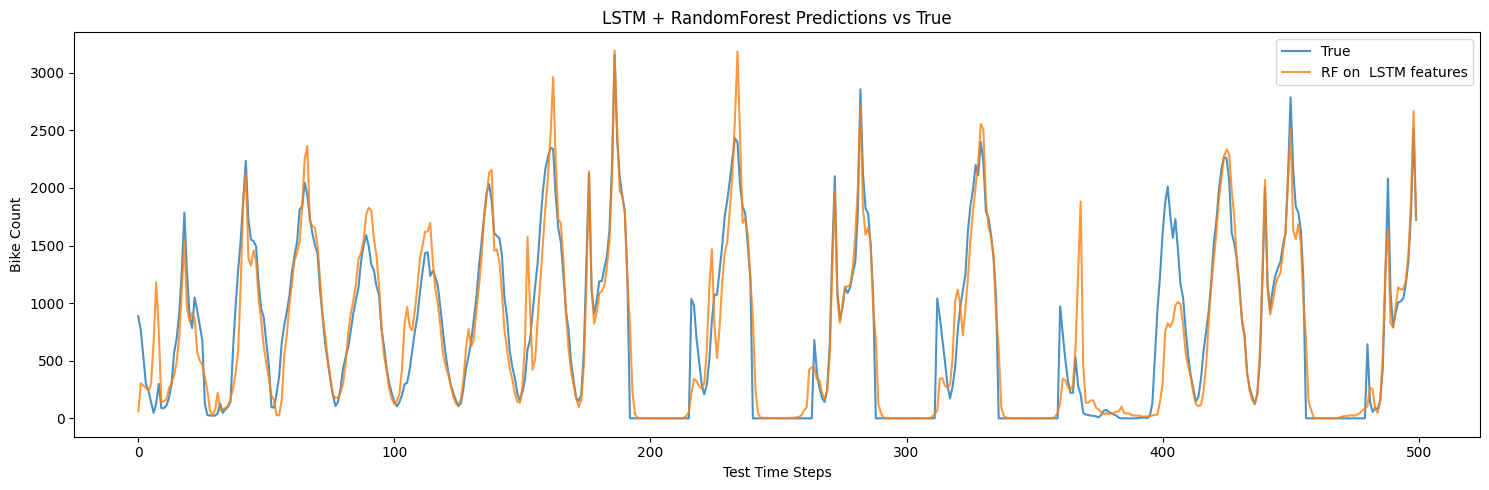

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})


    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

#  Feature selection and Scaling
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation 
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):  
        X_seq.append(X[i:i + seq_len])     
        y_seq.append(y[i + seq_len])       
    return np.array(X_seq), np.array(y_seq)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

#  LSTM Model 
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=34, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True, dropout=dropout)
        self.lstm3 = nn.LSTM(hidden_dim2, hidden_dim3, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim3, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        output = self.fc(out)
        return output

input_dim = n_features
model = LSTM(input_dim=input_dim, dropout=0.25)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Extract LSTM features for RF 
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out, _ = model.lstm1(xb)
            out, _ = model.lstm2(out)
            out, _ = model.lstm3(out)
            feats = out[:, -1, :]  
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats, test_targets_scaled = extract_features(model, test_loader_full, device)

train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets = scaler_y.inverse_transform(test_targets_scaled)

# RandomForest on LSTM features 
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# Evaluation on TRAIN set
rf_train_preds = rf.predict(train_feats)

y_true_train_orig = train_targets
y_pred_train_orig = rf_train_preds.reshape(-1, 1)

train_mse = np.mean((y_true_train_orig - y_pred_train_orig) ** 2)
train_rmse = np.sqrt(train_mse)
train_mae = np.mean(np.abs(y_true_train_orig - y_pred_train_orig))

safe_idx_train = y_true_train_orig > 10
train_mape = np.mean(
    np.abs((y_true_train_orig[safe_idx_train] - y_pred_train_orig[safe_idx_train]) /
           y_true_train_orig[safe_idx_train])
) * 100

train_smape = np.mean(
    2 * np.abs(y_pred_train_orig - y_true_train_orig) /
    (np.abs(y_true_train_orig) + np.abs(y_pred_train_orig) + 1e-8)
) * 100

train_r2 = r2_score(y_true_train_orig, y_pred_train_orig)

print("\n=== LSTM features + RandomForest TRAIN Results ===")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Train SMAPE: {train_smape:.2f}%")
print(f"Train R2: {train_r2:.4f}")


# Evaluation on TEST set 
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== LSTM features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# Prediction plot 
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on  LSTM features', alpha=0.8)
plt.legend()
plt.title('LSTM + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


Model 4: TCNN Current Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

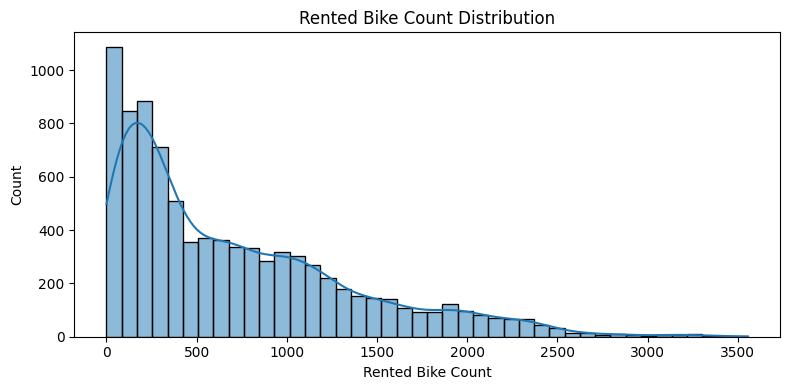

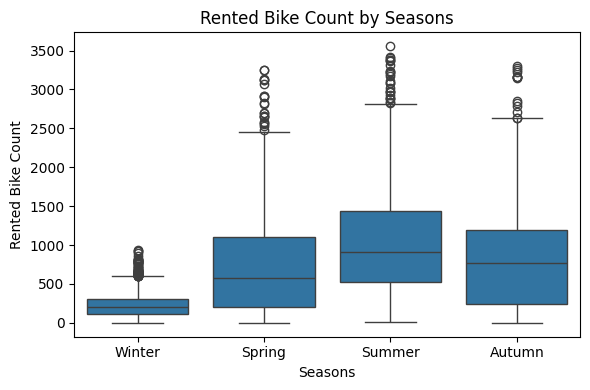

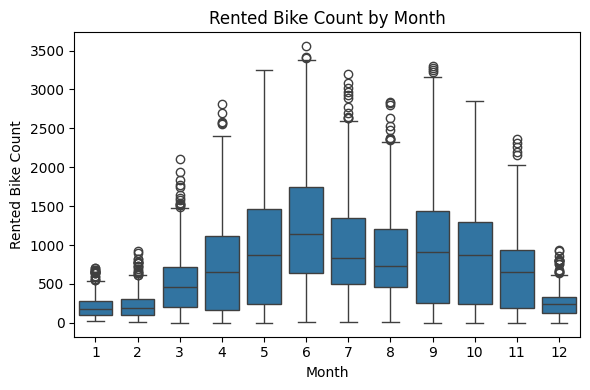

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\1088986045.py:81: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


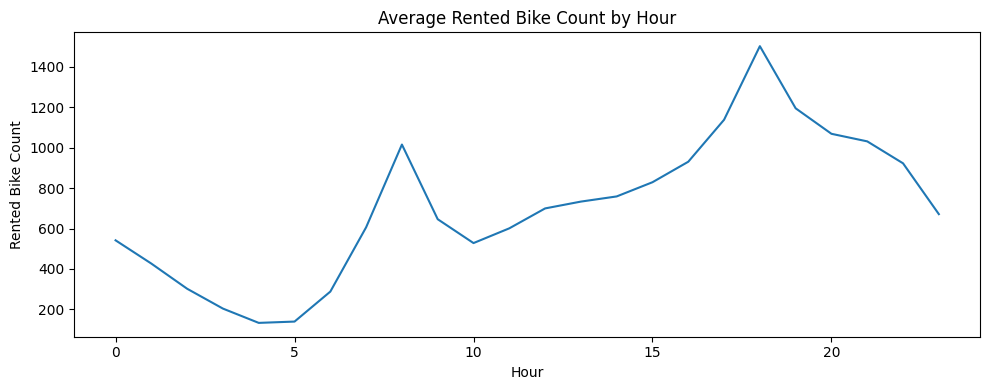

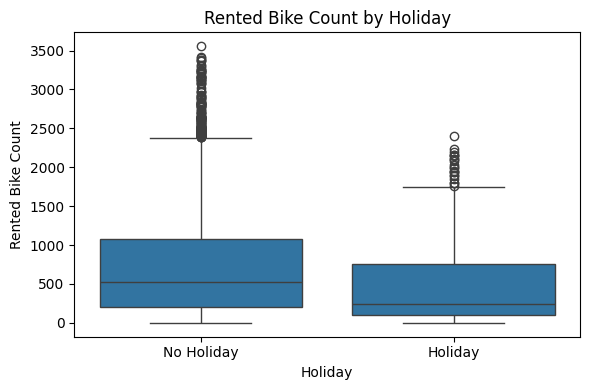

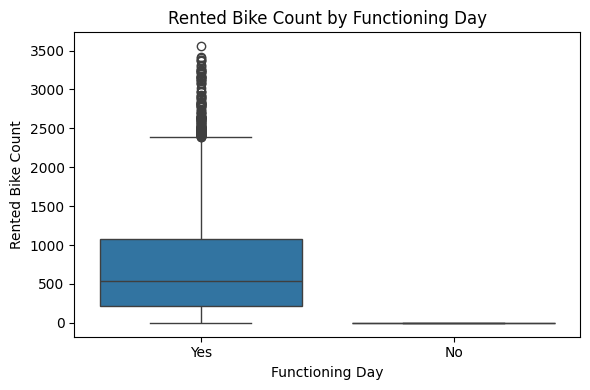

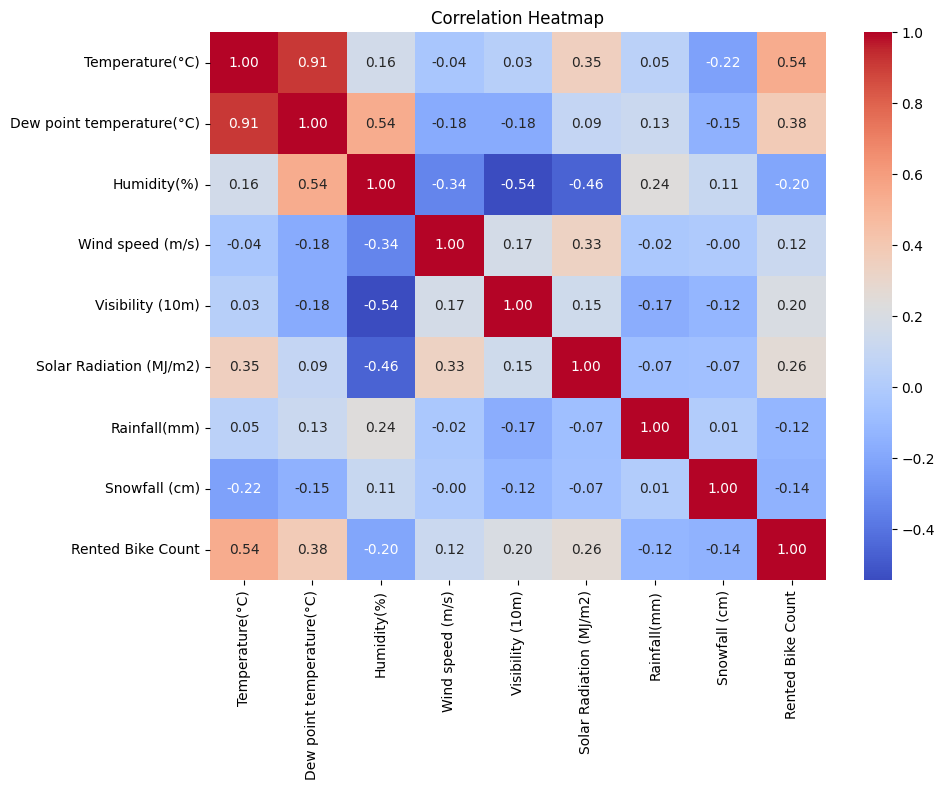

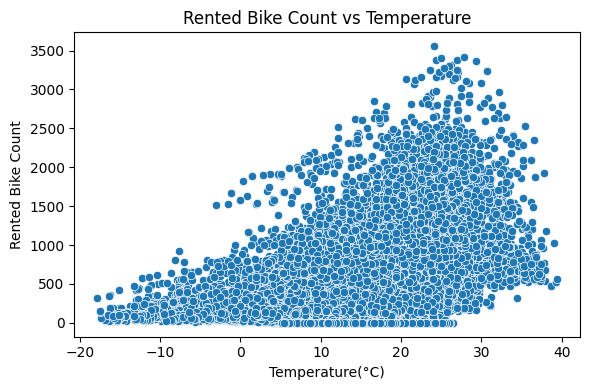

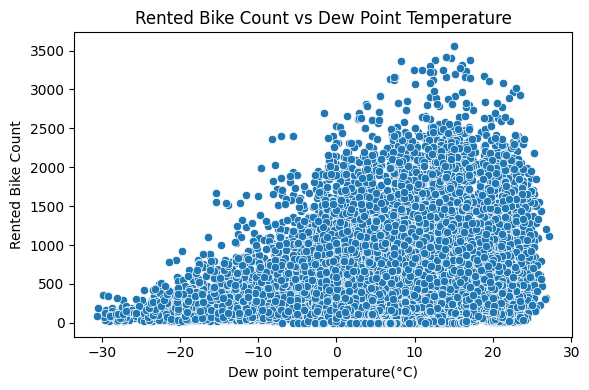

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\1088986045.py:129: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


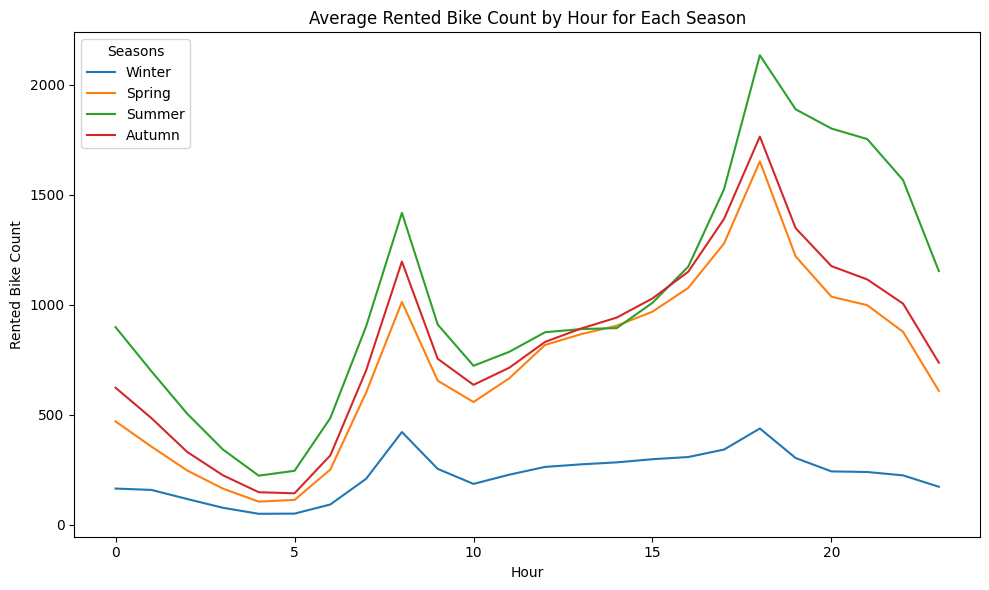

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15
TemporalCNN (avg+max): input 15 feats -> 80 conv channels
Epoch 1/100: train 0.3571 | val 0.1414
Epoch 2/100: train 0.1512 | val 0.1476
Epoch 3/100: train 0.1202 | val 0.1620
Epoch 4/100: train 0.0991 | val 0.1204
Epoch 5/100: train 0.0931 | val 0.1234
Epoch 6/100: train 0.0802 | val 0.0913
Epoch 7/100: train 0.0832 | val 0.1120
Epoch 8/100: train 0.0767 | val 0.0890
Epoch 9/100: train 0.0752 | val 0.2521
Epoch 10/100: train 0.0750 | val 0.1291
Epoch 11/100: train 0.0686 | val 0.0909
Epoch 12/100: train 0.0665 | val 0.0953
Epoch 13/100: train 0.0694 | val 0.0609
Epoch 14/100: train 0.0728 | val 0.1001
Epoch 15/100: train 0.0597 | val 0.0557
Epoch 16/100: train 0.0545 | val 0.0557
Epoch 17/100: train 0.0598 | val 0.1039
Epoch 18/100: train 0.0577 | val 0.0579
Epoch 19/100: train 0.0535 | val 0.0548
Epoch 20/100: train 0.0502 | val 0.0709
Epoch 21/100: train 0.0511 | val 0.0550
Epoch 22/100:

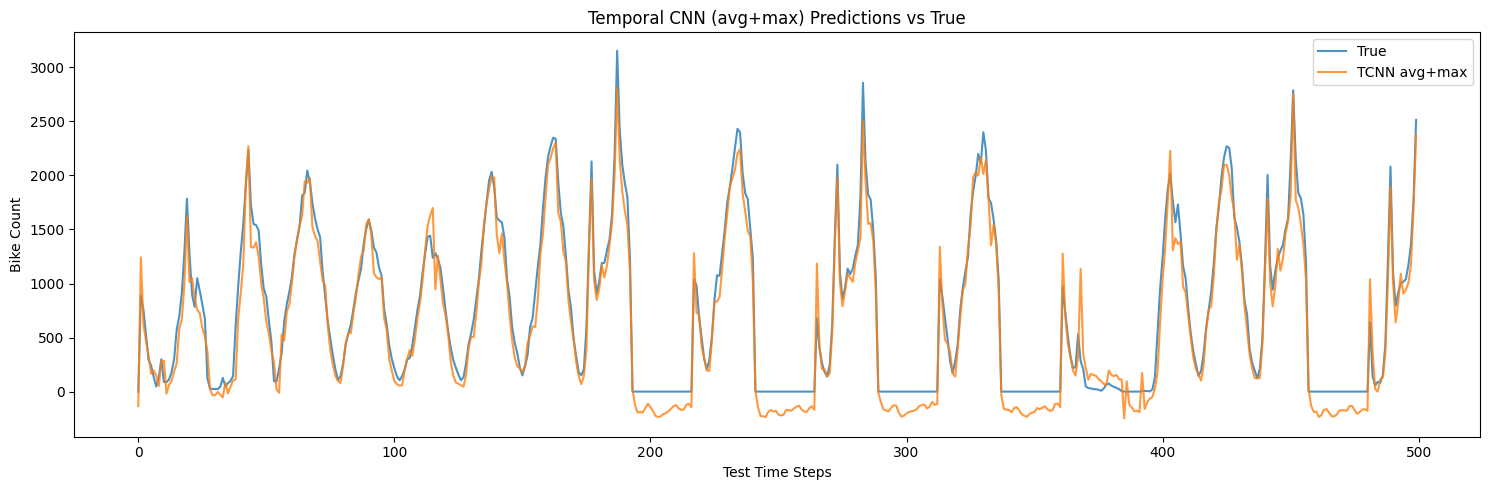

Temporal CNN (avg+max) training complete!


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping helper
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering 
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]
train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection & Scaling 
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# Temporal CNN model 
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)           
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)               
        avg_pool = x.mean(dim=2)        
        max_pool, _ = x.max(dim=2)      
        feats = torch.cat([avg_pool, max_pool], dim=1)  
        feats = self.dropout(feats)
        return self.fc(feats)           


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.2).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")


plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout() 
plt.show()

print("Temporal CNN (avg+max) training complete!")



Model 4: TCNN Next Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

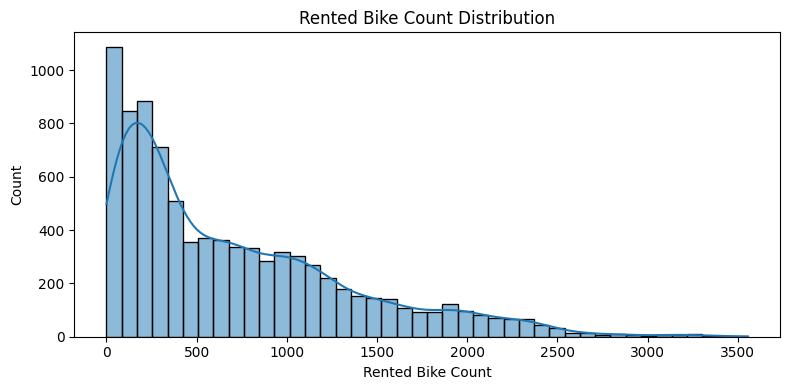

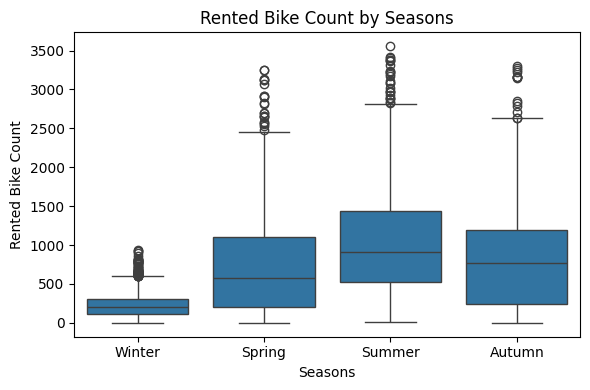

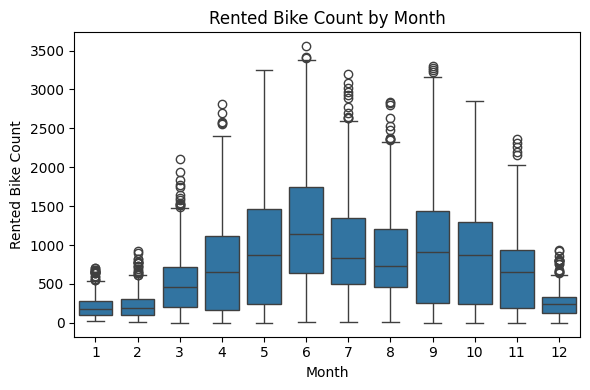

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\2047975664.py:81: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


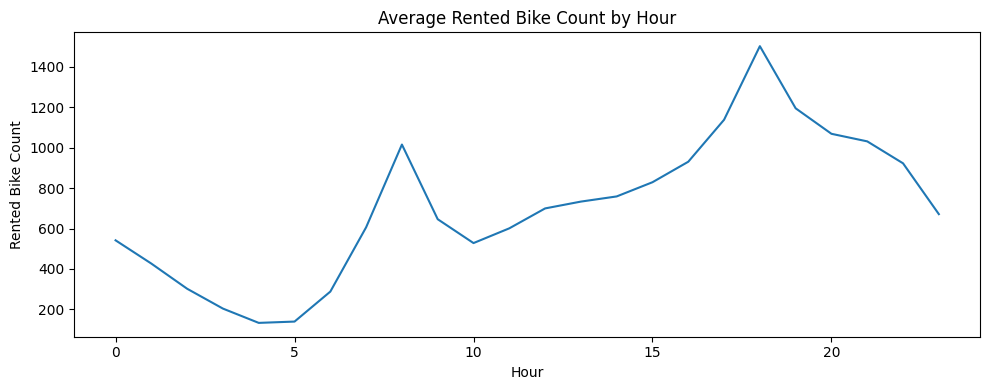

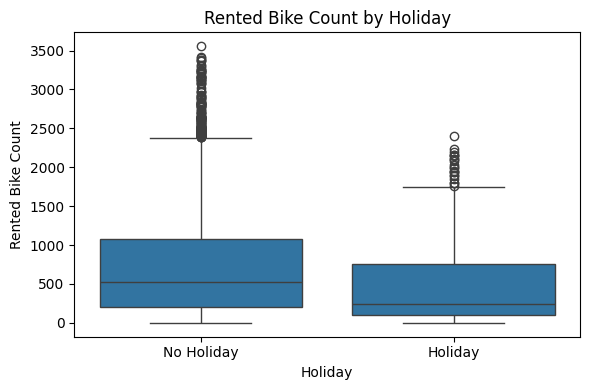

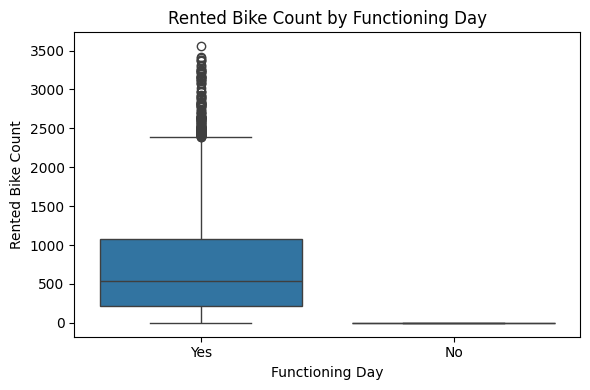

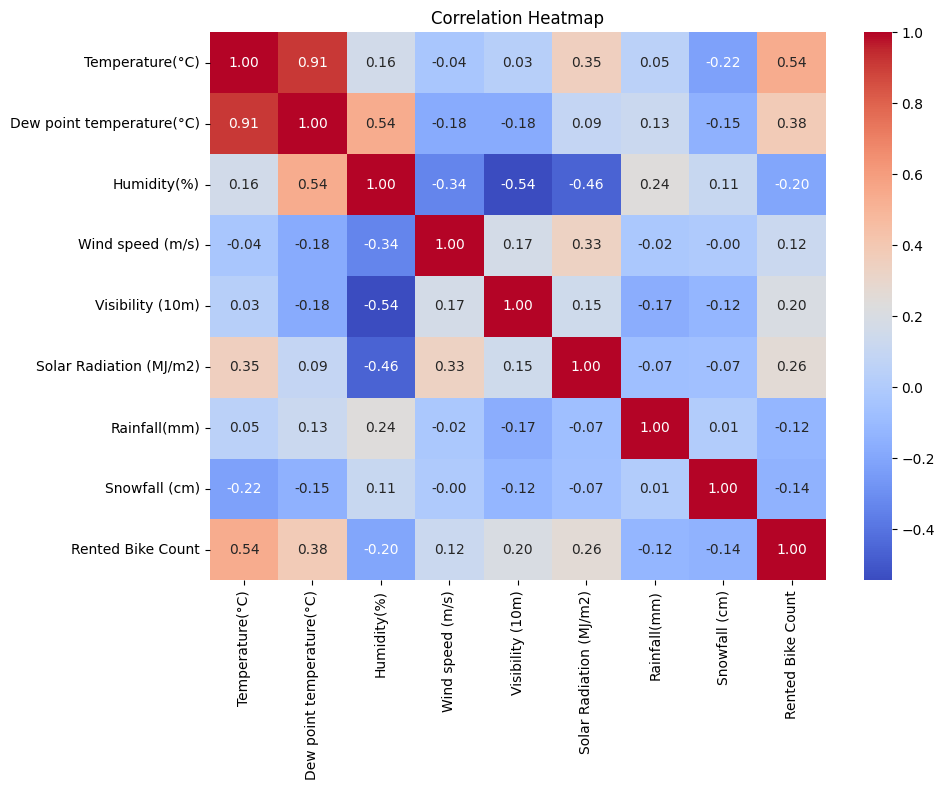

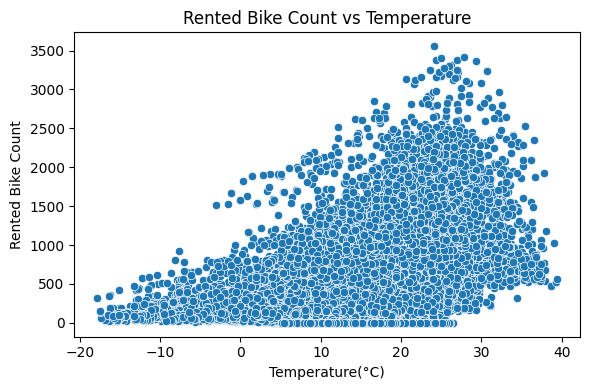

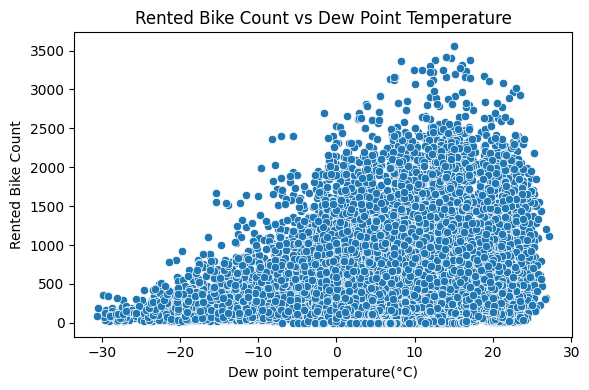

C:\Users\anavn\AppData\Local\Temp\ipykernel_23080\2047975664.py:129: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


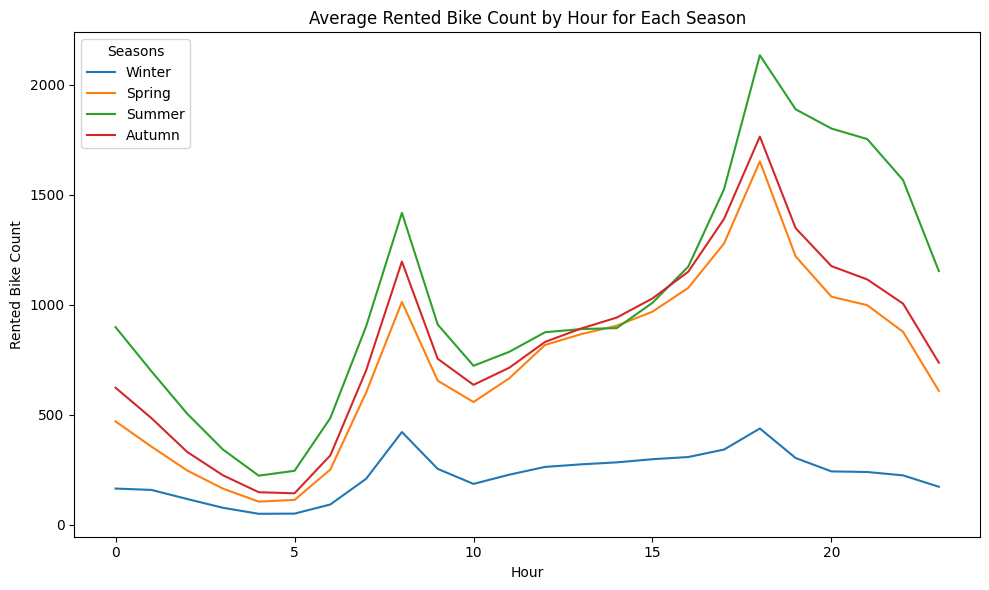

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 15), features: 15
TemporalCNN (avg+max): input 15 feats -> 80 conv channels
Epoch 1/100: train 0.3766 | val 0.3017
Epoch 2/100: train 0.2208 | val 0.2659
Epoch 3/100: train 0.1843 | val 0.1743
Epoch 4/100: train 0.1629 | val 0.2106
Epoch 5/100: train 0.1567 | val 0.1492
Epoch 6/100: train 0.1357 | val 0.1770
Epoch 7/100: train 0.1269 | val 0.1336
Epoch 8/100: train 0.1226 | val 0.1371
Epoch 9/100: train 0.1158 | val 0.2133
Epoch 10/100: train 0.1137 | val 0.1104
Epoch 11/100: train 0.1047 | val 0.1294
Epoch 12/100: train 0.1027 | val 0.1568
Epoch 13/100: train 0.1028 | val 0.1358
Epoch 14/100: train 0.0986 | val 0.1316
Epoch 15/100: train 0.0938 | val 0.1360
Epoch 16/100: train 0.0899 | val 0.1003
Epoch 17/100: train 0.0933 | val 0.1396
Epoch 18/100: train 0.0847 | val 0.1075
Epoch 19/100: train 0.0852 | val 0.1110
Epoch 20/100: train 0.0791 | val 0.1081
Epoch 21/100: train 0.0767 | val 0.1110
Epoch 22/100:

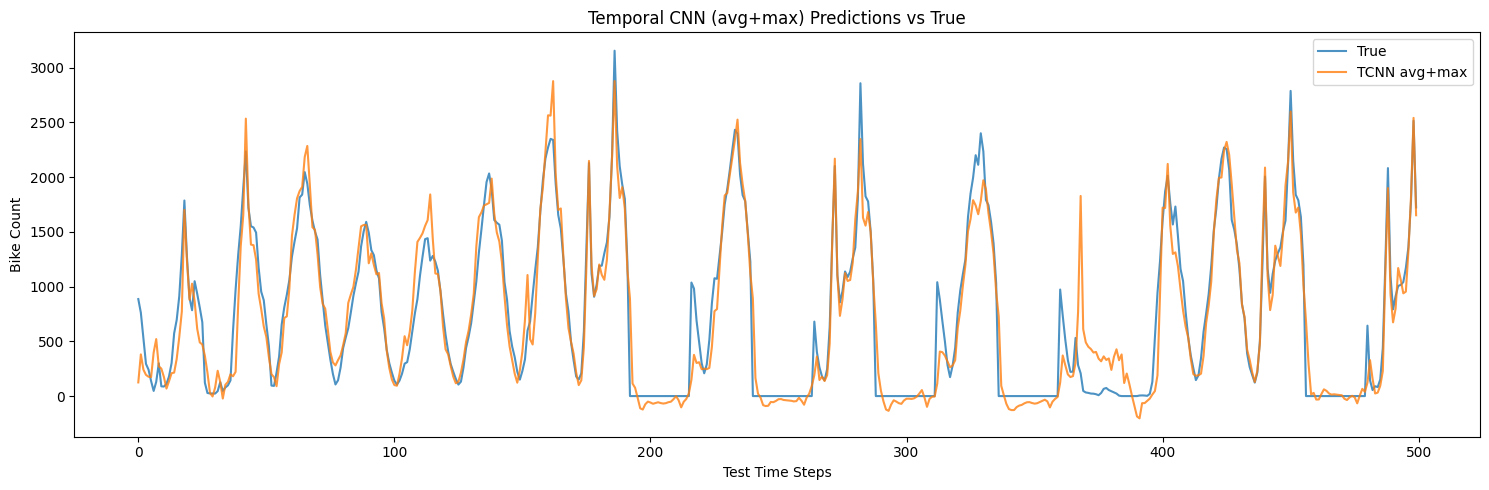

Temporal CNN (avg+max) training complete!


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random ; random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

# Early stopping helper
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# Feature engineering 
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train / test split 
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]
train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection & Scaling 
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Sequence creation
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# Temporal CNN model 
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)           
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)               
        avg_pool = x.mean(dim=2)        
        max_pool, _ = x.max(dim=2)      
        feats = torch.cat([avg_pool, max_pool], dim=1)  
        feats = self.dropout(feats)
        return self.fc(feats)           


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.2).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")


# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")


plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout() 
plt.show()

print("Temporal CNN (avg+max) training complete!")



Model 5: Transformer Current Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

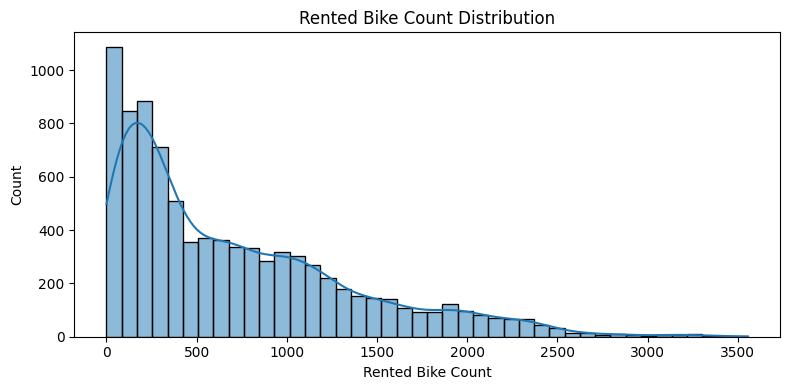

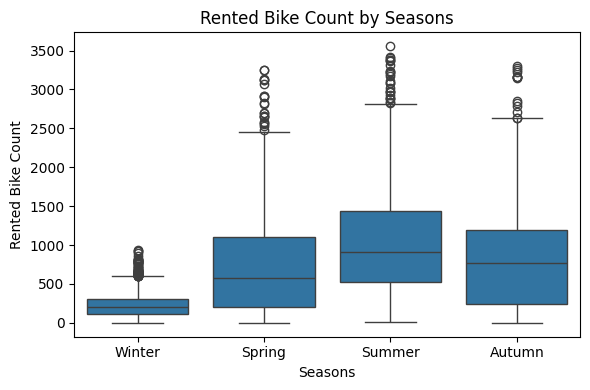

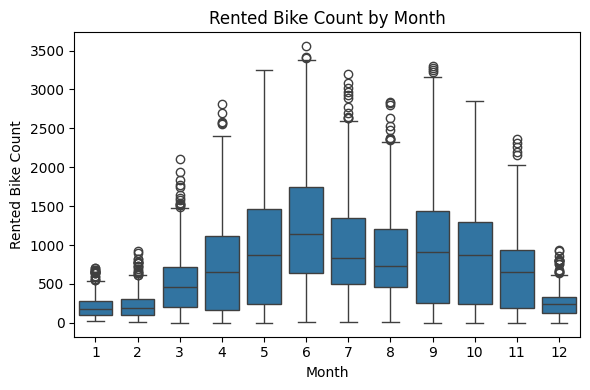

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\1121521489.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


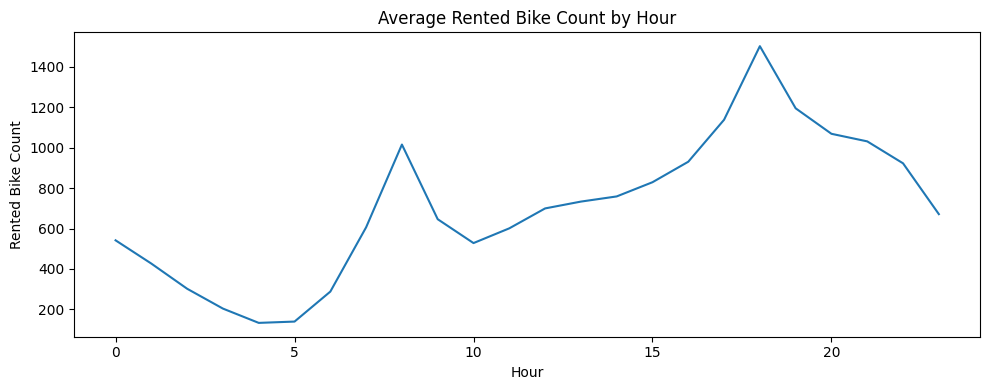

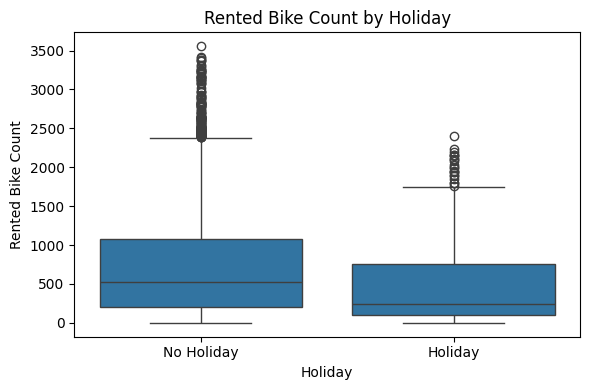

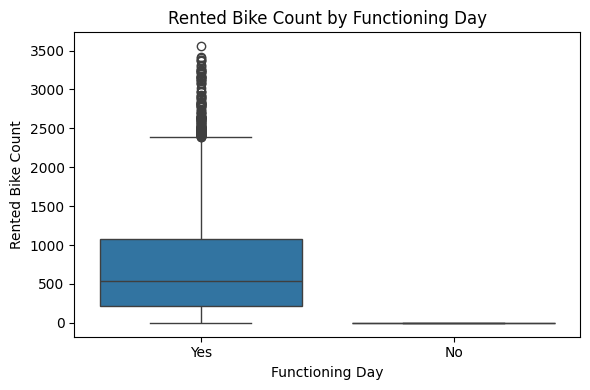

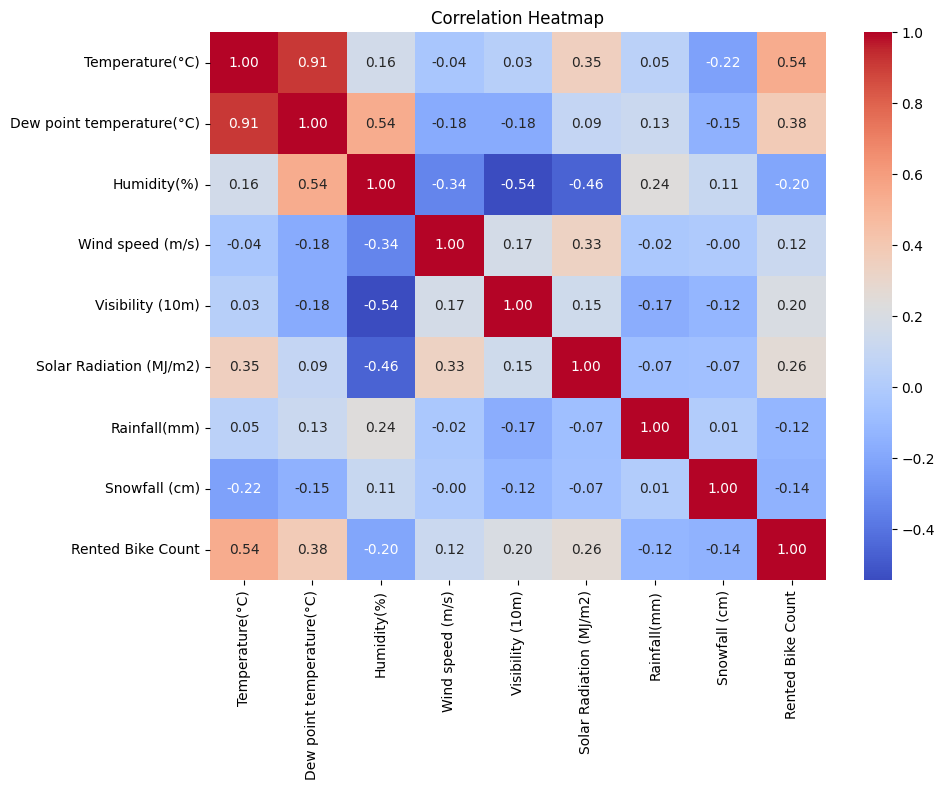

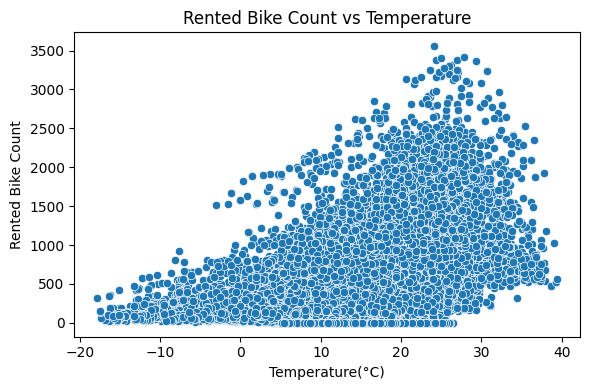

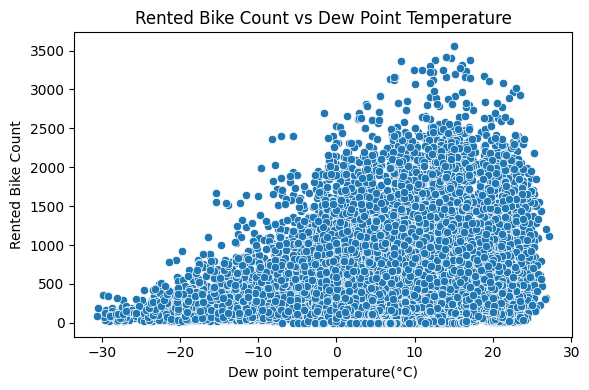

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\1121521489.py:139: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


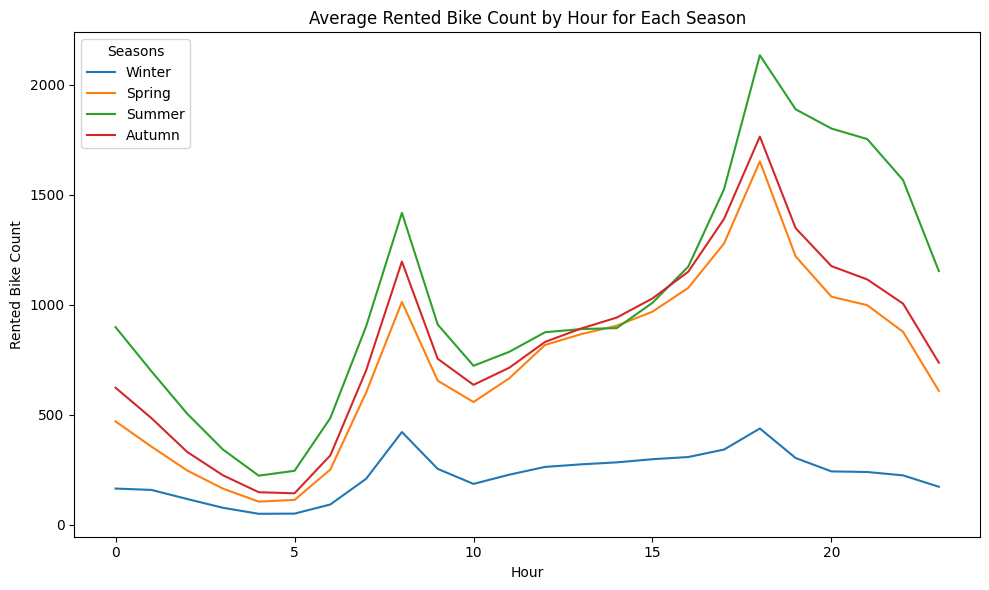


=== TOP 15 XGBoost Features ===

Selected top-15: ['lag_1', 'hour_sin', 'hour_cos', 'Solar Radiation (MJ/m2)', 'Seasons_Winter', 'Hour', 'DayOfWeek', 'Functioning Day', 'lag_3', 'Temperature(°C)', 'Holiday', 'Rainfall(mm)', 'lag_2', 'Month', 'is_evening_peak']
Training on 5916 train sequences, 1044 val sequences
Sequence shape: (5916, 24, 15), features: 15
TimeSeriesTransformer: input 15 feats -> d_model=64, heads=8, layers=3
Epoch 1/100: train 0.2392 | val 0.1852
Epoch 2/100: train 0.1267 | val 0.1248
Epoch 3/100: train 0.1004 | val 0.1075
Epoch 4/100: train 0.0856 | val 0.0832
Epoch 5/100: train 0.0745 | val 0.0788
Epoch 6/100: train 0.0682 | val 0.0795
Epoch 7/100: train 0.0625 | val 0.0765
Epoch 8/100: train 0.0585 | val 0.0768
Epoch 9/100: train 0.0542 | val 0.0631
Epoch 10/100: train 0.0503 | val 0.0562
Epoch 11/100: train 0.0482 | val 0.0495
Epoch 12/100: train 0.0476 | val 0.0667
Epoch 13/100: train 0.0438 | val 0.0551
Epoch 14/100: train 0.0424 | val 0.0545
Epoch 15/100: trai

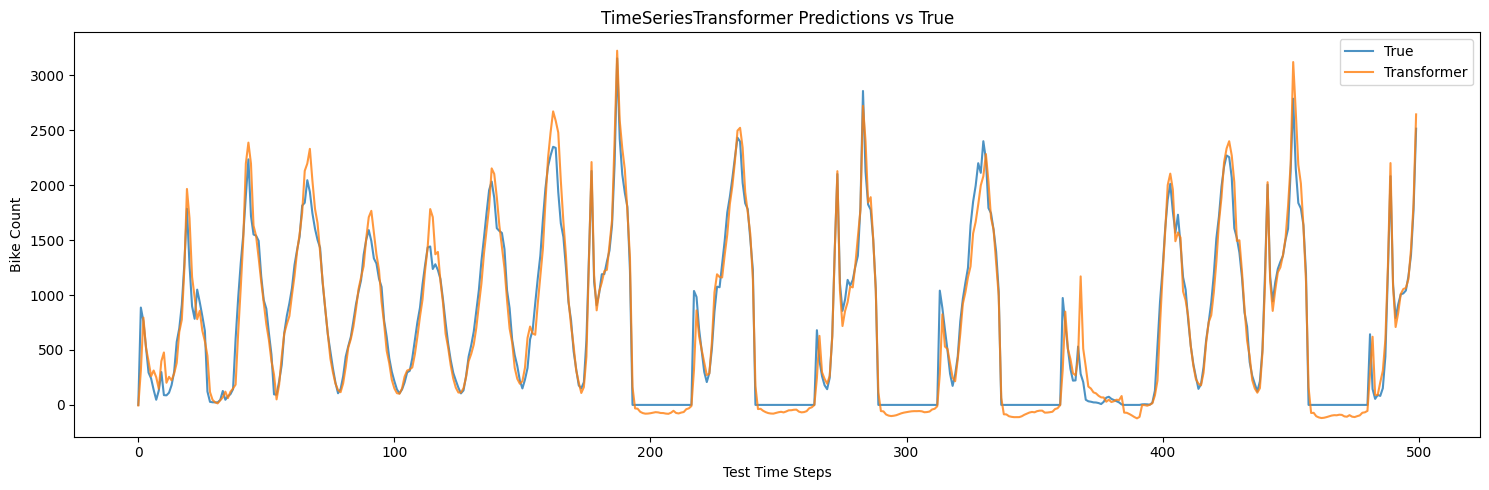


TimeSeriesTransformer training complete!


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


# Early stopping helper 
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()


# Feature Engineering 
def feature_engineering(df, max_lag=24):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'No': 0, 'Yes': 1})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = feature_engineering(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]
 
# Train / test split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection and Scaling
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)
print("\n=== TOP 15 XGBoost Features ===")

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print(f"\nSelected top-{top_n}: {selected_features}")

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


# Sequence creation 
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")


# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]


# Pure Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=8,
        num_layers=3,
        dim_feedforward=128,
        dropout=0.2
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        x_t = self.input_proj(x)          
        x_t = self.pos_encoder(x_t)       
        x_t = self.encoder(x_t)           
        last_t = x_t[:, -1, :]            
        return self.fc_out(last_t)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TimeSeriesTransformer(
    input_size=n_features,
    d_model=64,
    nhead=8,
    num_layers=3,
    dim_feedforward=128,
    dropout=0.2
).to(device)

print(
    f"TimeSeriesTransformer: input {n_features} feats "
    f"-> d_model={model.input_proj.out_features}, "
    f"heads={model.encoder.layers[0].self_attn.num_heads}, "
    f"layers={len(model.encoder.layers)}"
)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== TimeSeriesTransformer TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== TimeSeriesTransformer TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Transformer', alpha=0.8)
plt.legend()
plt.title('TimeSeriesTransformer Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("\nTimeSeriesTransformer training complete!")


Model 5: Transformer Next Hour

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

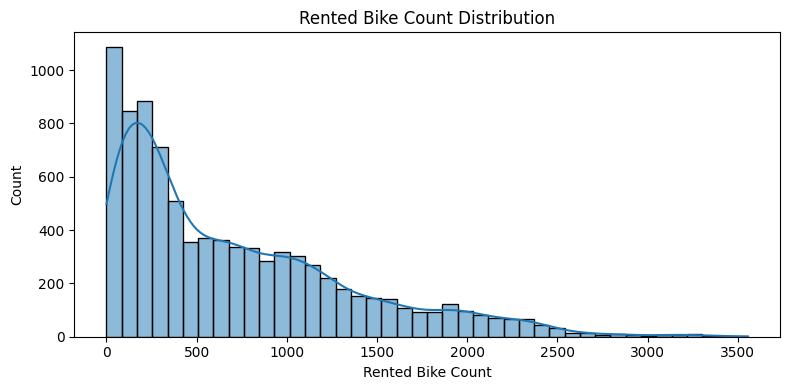

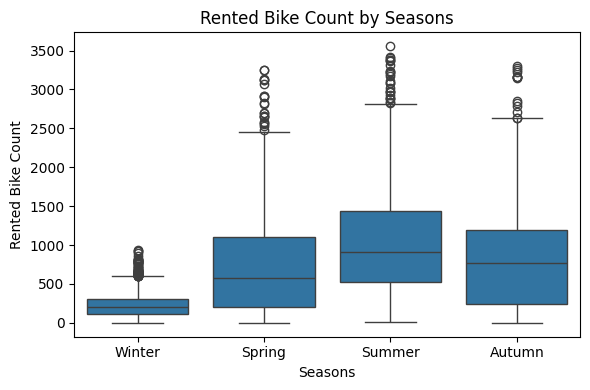

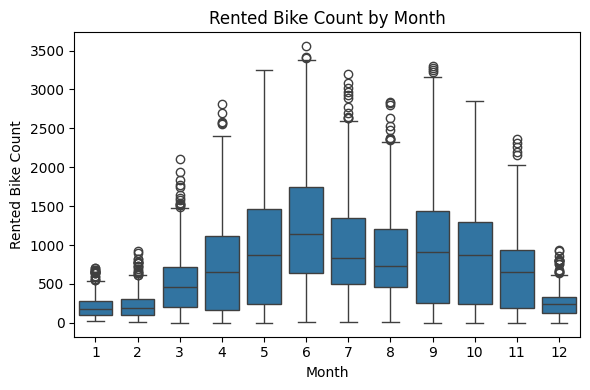

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\3256584992.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


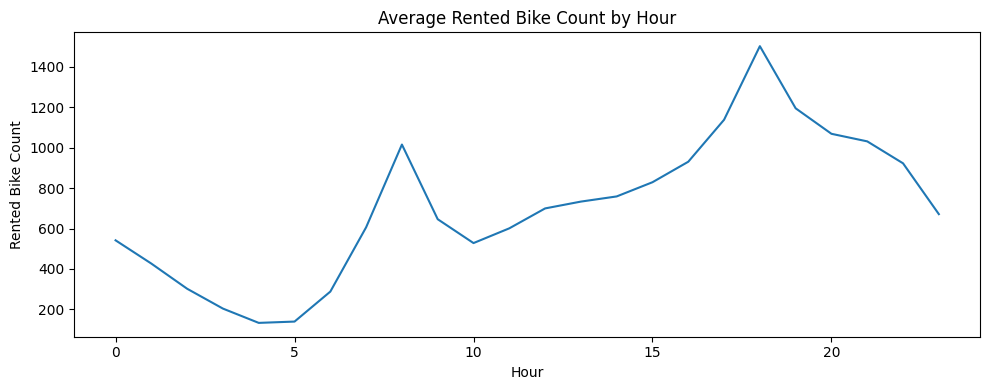

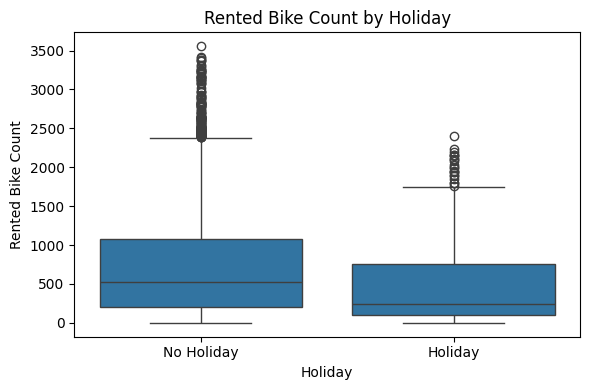

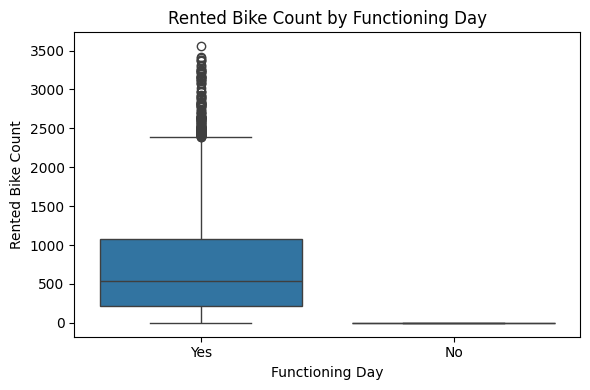

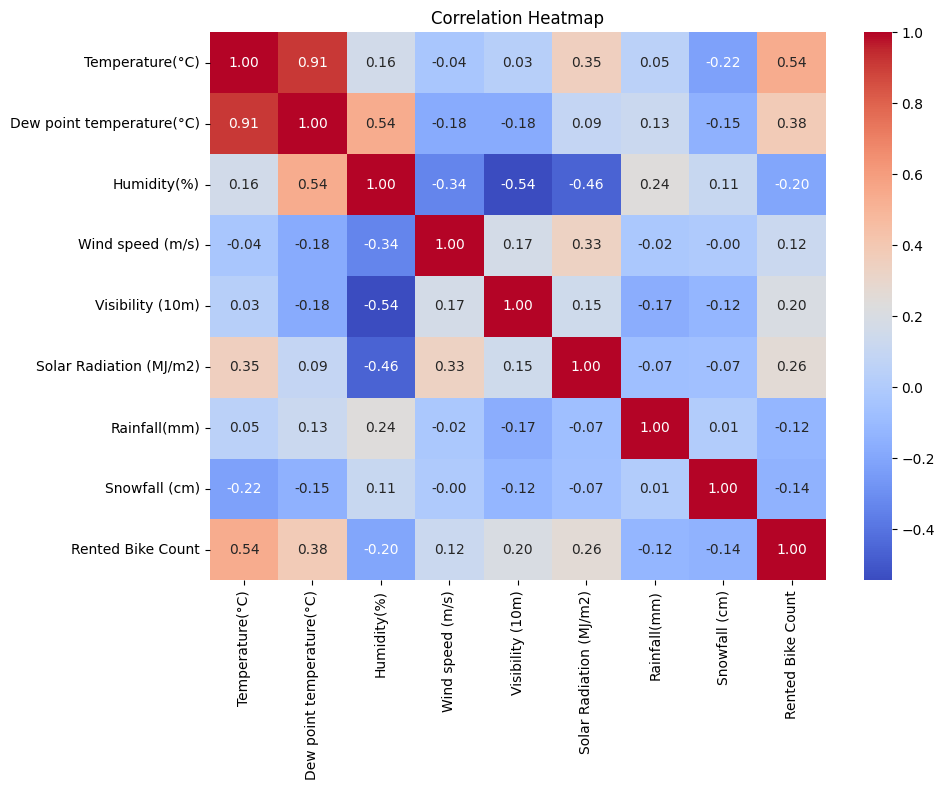

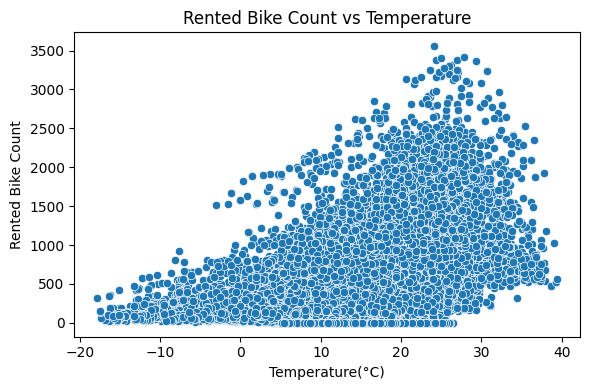

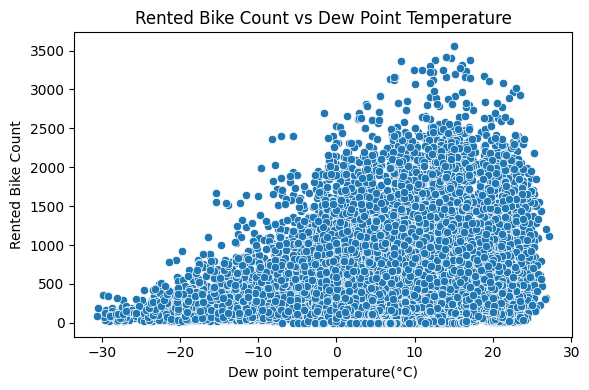

C:\Users\anavn\AppData\Local\Temp\ipykernel_16892\3256584992.py:139: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


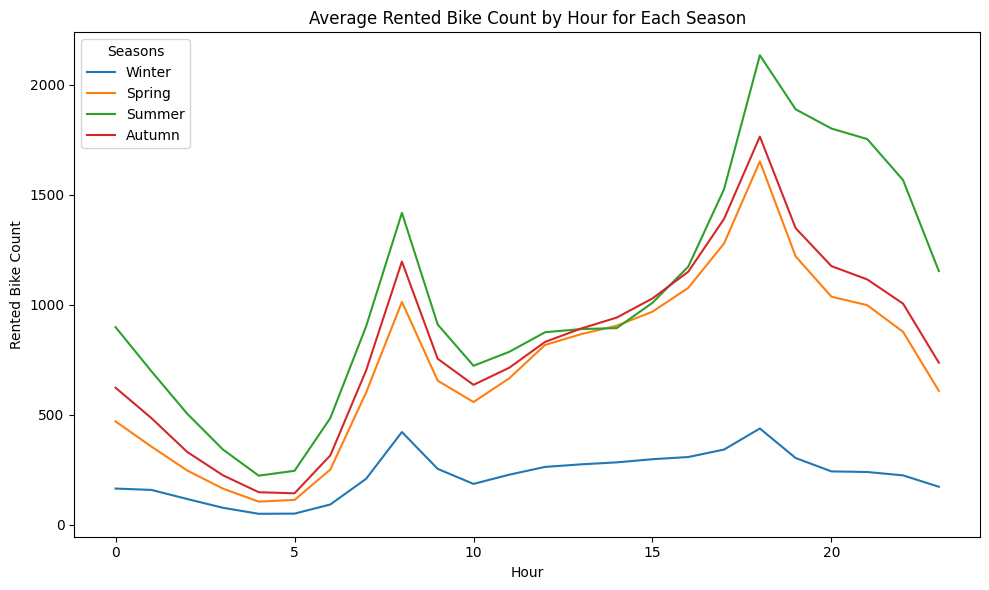


=== TOP 15 XGBoost Features ===

Selected top-15: ['lag_1', 'hour_sin', 'hour_cos', 'Solar Radiation (MJ/m2)', 'Seasons_Winter', 'Hour', 'DayOfWeek', 'Functioning Day', 'lag_3', 'Temperature(°C)', 'Holiday', 'Rainfall(mm)', 'lag_2', 'Month', 'is_evening_peak']
Training on 5916 train sequences, 1044 val sequences
Sequence shape: (5916, 24, 15), features: 15
TimeSeriesTransformer: input 15 feats -> d_model=64, heads=8, layers=3
Epoch 1/100: train 0.3104 | val 0.2983
Epoch 2/100: train 0.1925 | val 0.2081
Epoch 3/100: train 0.1548 | val 0.1646
Epoch 4/100: train 0.1349 | val 0.1332
Epoch 5/100: train 0.1158 | val 0.1346
Epoch 6/100: train 0.1070 | val 0.1230
Epoch 7/100: train 0.0987 | val 0.1237
Epoch 8/100: train 0.0949 | val 0.1129
Epoch 9/100: train 0.0877 | val 0.1139
Epoch 10/100: train 0.0842 | val 0.1118
Epoch 11/100: train 0.0820 | val 0.1054
Epoch 12/100: train 0.0778 | val 0.1109
Epoch 13/100: train 0.0733 | val 0.0965
Epoch 14/100: train 0.0726 | val 0.1045
Epoch 15/100: trai

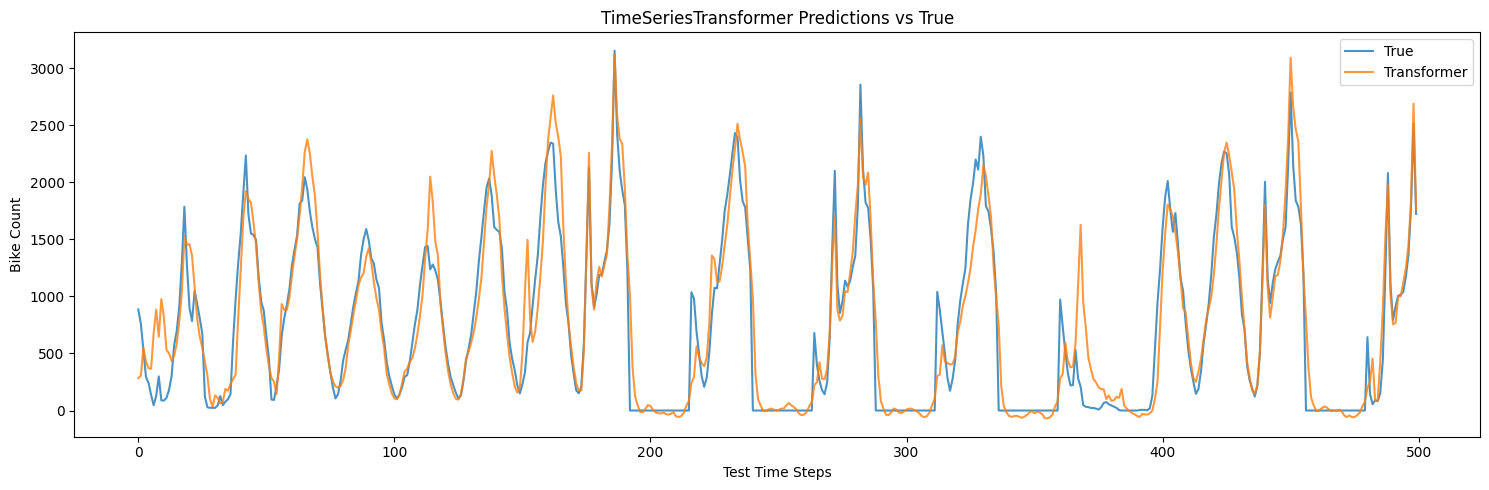


TimeSeriesTransformer training complete!


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


# Early stopping helper 
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# Loading Data and EDA
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()


# Feature Engineering 
def feature_engineering(df, max_lag=24):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'No': 0, 'Yes': 1})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = feature_engineering(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]
 
# Train / test split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection and Scaling
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)
print("\n=== TOP 15 XGBoost Features ===")

top_n = 15
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print(f"\nSelected top-{top_n}: {selected_features}")

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


# Sequence creation 
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")


# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]


# Pure Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=8,
        num_layers=3,
        dim_feedforward=128,
        dropout=0.2
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        x_t = self.input_proj(x)          
        x_t = self.pos_encoder(x_t)       
        x_t = self.encoder(x_t)           
        last_t = x_t[:, -1, :]            
        return self.fc_out(last_t)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TimeSeriesTransformer(
    input_size=n_features,
    d_model=64,
    nhead=8,
    num_layers=3,
    dim_feedforward=128,
    dropout=0.2
).to(device)

print(
    f"TimeSeriesTransformer: input {n_features} feats "
    f"-> d_model={model.input_proj.out_features}, "
    f"heads={model.encoder.layers[0].self_attn.num_heads}, "
    f"layers={len(model.encoder.layers)}"
)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# Training with early stopping 
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluation on TRAIN set 
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== TimeSeriesTransformer TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# Evaluation on TEST set 
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== TimeSeriesTransformer TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Transformer', alpha=0.8)
plt.legend()
plt.title('TimeSeriesTransformer Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("\nTimeSeriesTransformer training complete!")
